**Satellite Simulation** \
(Divya Ramachandran,Hadis  Banafsheh, Suvan Kumar)

In [20]:
#SNODAS Dataset

In [21]:
import os
import requests
import zipfile
import geopandas as gpd
from shapely.geometry import Polygon

from datetime import datetime, timedelta, timezone

start = datetime(2024, 1, 1, tzinfo=timezone.utc)
end = datetime(2024, 5, 30, tzinfo=timezone.utc)
frame_duration = timedelta(days=1)
num_frames = int(1 + (end - start) / frame_duration)

# automatically download/extract watershed boundary shapefiles
for wbd in [10]:
    if not os.path.isfile(f"WBD_{wbd}_HU2_Shape/Shape/WBDHU2.shp"):
        print(f"Downloading/extracting WBD {wbd}")
        r = requests.get(
            f"https://prd-tnm.s3.amazonaws.com/StagedProducts/Hydrography/WBD/HU2/Shape/WBD_{wbd}_HU2_Shape.zip"
        )
        with open(f"WBD_{wbd}_HU2_Shape.zip", "wb") as zip_file:
            zip_file.write(r.content)
        with zipfile.ZipFile(f"WBD_{wbd}_HU2_Shape.zip", 'r') as zip_file:
            zip_file.extractall(f"WBD_{wbd}_HU2_Shape")

mo_basin = gpd.read_file("WBD_10_HU2_Shape/Shape/WBDHU2.shp")
mo_basin = gpd.GeoSeries(Polygon(mo_basin.iloc[0].geometry.exterior), crs="EPSG:4326")

# access us states shapefile
us_map = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_20m.zip")
conus = us_map[~us_map.STUSPS.isin(["AK", "HI", "PR"])].to_crs("EPSG:4326")
# note: requires gdal (has platform-specific binaries)
# recommend conda distribution: `conda install -c conda-forge gdal`
from osgeo import gdal

from datetime import datetime
import gzip
import os
import requests
import shutil
import tarfile
import tempfile

import pandas as pd
import rioxarray as rxr
import xarray as xr

dates = pd.date_range(start, end)
snodas_dir = "SNODAS"
if not os.path.exists(snodas_dir):
    os.makedirs(snodas_dir)

for date in dates:
    # Make sure the date is timezone-aware
    date = datetime(date.year, date.month, date.day, tzinfo=timezone.utc)

    file_label = f"us_ssmv11034tS__T0001TTNATS{date.strftime('%Y')}{date.strftime('%m')}{date.strftime('%d')}05HP001.nc"
    
    # check if file already exists
    if os.path.isfile(os.path.join(snodas_dir, file_label)):
        print("Skipping " + file_label)
        continue
    print("Processing " + file_label)
    dir_label = f"SNODAS_{date.strftime('%Y%m%d')}"
    # request the .tar file
    r = requests.get(
        "https://noaadata.apps.nsidc.org/NOAA/G02158/masked/" + 
        f"{date.strftime('%Y')}/{date.strftime('%m')}_{date.strftime('%b')}/" +
        dir_label + ".tar"
    )
    # do work in temp directory
    with tempfile.TemporaryDirectory() as tmp_dir:
        # save the .tar file
        with open(os.path.join(tmp_dir, dir_label + ".tar"), "wb") as tar_file:
            tar_file.write(r.content)
        # open and extract the .tar file
        with tarfile.open(os.path.join(tmp_dir, dir_label + ".tar"), "r") as tar_file:
            tar_file.extractall(tmp_dir)
        # iterate through all files
        for filename in os.listdir(tmp_dir):
            if os.path.isfile(os.path.join(tmp_dir, filename)) and all(s in filename for s in ["v11034", ".dat.gz"]):
                # unzip the swe .gz file
                with gzip.open(os.path.join(tmp_dir, filename), "rb") as gz_in:
                    with open(os.path.join(tmp_dir, filename.replace(".gz", "")), "wb") as gz_out:
                        shutil.copyfileobj(gz_in, gz_out)
                # write the .hdr file
                with open(os.path.join(tmp_dir, filename.replace(".dat.gz", ".hdr")), "w") as hdr_file:
                    hdr_file.write(
                        "ENVI\n"
                        "samples = 6935\n" +
                        "lines = 3351\n" +
                        "bands = 1\n" +
                        "header offset = 0\n" + 
                        "file type = ENVI Standard\n" + 
                        "data type = 2\n" +
                        "interleave = bsq\n" +
                        "byte order = 1"
                    )
                # run the gdal translator
                if date < datetime(2013, 10, 1, tzinfo=timezone.utc):
                    command = " ".join([
                        "gdal_translate",
                        "-of NetCDF",
                        "-a_srs EPSG:4326",
                        "-a_nodata -9999",
                        "-a_ullr -124.73375000000000 52.87458333333333 -66.94208333333333 24.94958333333333",
                        os.path.join(tmp_dir, filename.replace(".dat.gz", ".dat")),
                        os.path.join(snodas_dir, filename.replace(".dat.gz", ".nc"))
                    ])
                else:
                    command = " ".join([
                        "gdal_translate",
                        "-of NetCDF",
                        "-a_srs EPSG:4326",
                        "-a_nodata -9999",
                        "-a_ullr -124.73333333333333 52.87500000000000 -66.94166666666667 24.95000000000000",
                        os.path.join(tmp_dir, filename.replace(".dat.gz", ".dat")),
                        os.path.join(snodas_dir, filename.replace(".dat.gz", ".nc"))
                    ])
                if os.system(command) > 0: 
                    print(f"Error processing command `{command}`")

print("Merging datasets...")
ds = xr.combine_by_coords(
    [
        rxr.open_rasterio(
            os.path.join(
                snodas_dir, 
                f"us_ssmv11034tS__T0001TTNATS{date.strftime('%Y')}{date.strftime('%m')}{date.strftime('%d')}05HP001.nc"
            )
        ).rio.clip(mo_basin.envelope).assign_coords(time=date).expand_dims(dim="time")
        for date in dates
    ], 
    combine_attrs="drop_conflicts"
).sel(band=1).rename_vars({"Band1": "SWE"})
ds.SWE.attrs["long_name"] = "Snow Water Equivalent"
ds.SWE.attrs["units"] = "mm"

print("Writing snodas-merged.nc")
ds.to_netcdf(os.path.join(snodas_dir, "snodas-merged.nc"))


Skipping us_ssmv11034tS__T0001TTNATS2024010105HP001.nc
Skipping us_ssmv11034tS__T0001TTNATS2024010205HP001.nc
Skipping us_ssmv11034tS__T0001TTNATS2024010305HP001.nc
Skipping us_ssmv11034tS__T0001TTNATS2024010405HP001.nc
Skipping us_ssmv11034tS__T0001TTNATS2024010505HP001.nc
Skipping us_ssmv11034tS__T0001TTNATS2024010605HP001.nc
Skipping us_ssmv11034tS__T0001TTNATS2024010705HP001.nc
Skipping us_ssmv11034tS__T0001TTNATS2024010805HP001.nc
Skipping us_ssmv11034tS__T0001TTNATS2024010905HP001.nc
Skipping us_ssmv11034tS__T0001TTNATS2024011005HP001.nc
Skipping us_ssmv11034tS__T0001TTNATS2024011105HP001.nc
Skipping us_ssmv11034tS__T0001TTNATS2024011205HP001.nc
Skipping us_ssmv11034tS__T0001TTNATS2024011305HP001.nc
Skipping us_ssmv11034tS__T0001TTNATS2024011405HP001.nc
Skipping us_ssmv11034tS__T0001TTNATS2024011505HP001.nc
Skipping us_ssmv11034tS__T0001TTNATS2024011605HP001.nc
Skipping us_ssmv11034tS__T0001TTNATS2024011705HP001.nc
Skipping us_ssmv11034tS__T0001TTNATS2024011805HP001.nc
Skipping u

In [ ]:
#Down sampling the resolution from 1km to 100km
from rasterio.enums import Resampling
swe = ds.SWE.rio.reproject(ds.SWE.rio.crs, shape=(ds.SWE.shape[1]//100, ds.SWE.shape[2]//100), resampling=Resampling.average)

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
from datetime import datetime

# Ensure dimensions of size 1 are squeezed out
if 'band' in swe.dims and swe.sizes['band'] == 1:
    swe = swe.squeeze('band')

# Mask NaN values in SWE
swe_masked = swe.where(~np.isnan(swe))

# Calculate the absolute SWE difference between consecutive time steps
swe_diff_abs = abs(swe_masked.diff(dim='time')).where(~np.isnan(swe_masked.diff(dim='time')))

# Add a zero difference for the first time step to match the length
swe_diff_abs = xr.concat([xr.zeros_like(swe.isel(time=0)), swe_diff_abs], dim='time')

# Set the threshold for SWE change
threshold = 15

# Create a list to store the results
results = []

# Iterate through the dataset and check for each grid cell
for t in range(len(swe_diff_abs.time)):
    # Extract the SWE difference for the current time step
    swe_diff_time = swe_diff_abs.isel(time=t)
    
    # Check if any grid cell exceeds the threshold
    grid_cells_exceeding_threshold = swe_diff_time.where(swe_diff_time > threshold, drop=True)
    
    if not grid_cells_exceeding_threshold.isnull().all():
        # Get the date of the current time step
        date = swe['time'].isel(time=t).values.astype('datetime64[D]')
        
        # Convert to a Python datetime object to access 'year'
        date_obj = pd.to_datetime(date)
        
        # Calculate the number of days since the start of the year (January 1st)
        day_from_start = (date_obj - datetime(date_obj.year, 1, 1)).days + 1
        
        # Append the results
        results.append([date, day_from_start])

# Convert results to a DataFrame
dates_df = pd.DataFrame(results, columns=["Date", "Days_from_start"])

# Calculate the interarrival days by taking the difference between consecutive dates
dates_df['Interarrival_days'] = dates_df['Date'].diff().fillna(pd.Timedelta(0)).dt.days

# Remove the first row
dates_df = dates_df.iloc[1:].reset_index(drop=True)

# Save the DataFrame to a CSV file
# output_csv = 'dates_with_interarrival.csv'
# dates_df.to_csv(output_csv, index=False)

# Print confirmation and show a preview of the DataFrame
# print(f"Dates where SWE change exceeds the threshold saved to '{output_csv}'.")
print(dates_df.head())


        Date  Days_from_start  Interarrival_days
0 2024-01-10               10                  1
1 2024-01-11               11                  1
2 2024-01-13               13                  2
3 2024-01-15               15                  2
4 2024-01-17               17                  2


95% Confidence Interval for the Mean: (1.681975, 1.825025)
Next Image Request will be in: 1 day, 0:00:00


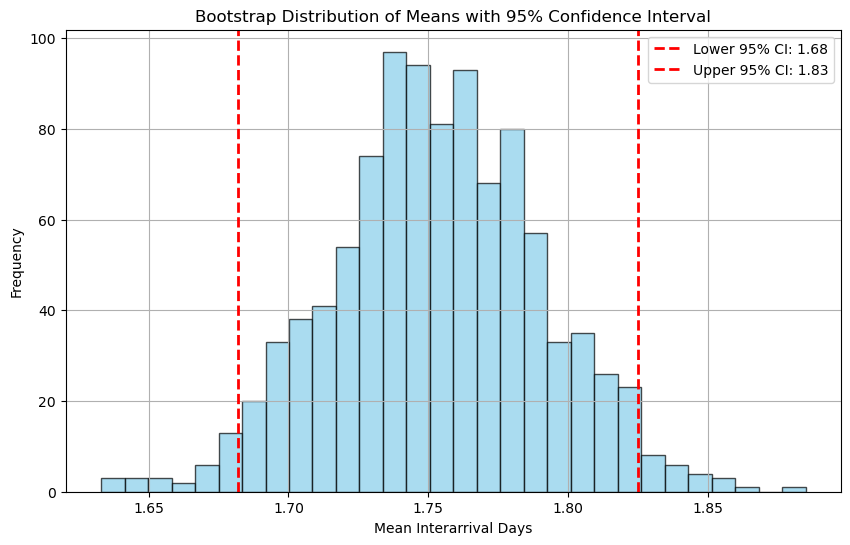

In [ ]:
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt

def bootstrap_interarrivals(dates_df, n_iterations=1000):
    """
    Perform bootstrap sampling on the inter-arrival times and calculate the mean and confidence intervals.

    Parameters:
    dates_df (DataFrame): DataFrame containing the inter-arrival days data.
    n_iterations (int): The number of bootstrap samples to generate.

    Returns:
    tuple: A tuple containing the list of bootstrap samples, and the lower and upper bounds of the 95% confidence interval for the mean.
    """
    # Create a list to store the bootstrap samples
    bootstrap_samples = []
    bootstrap_means = []

    # Perform bootstrap sampling
    for i in range(n_iterations):
        # Sample with replacement from the 'Interarrival_days' column
        sample = dates_df['Interarrival_days'].sample(n=1000, replace=True)
        bootstrap_samples.append(sample)  
        sample_mean = np.mean(sample) 
        bootstrap_means.append(sample_mean)

    # Calculate the 95% confidence interval (using the 2.5th and 97.5th percentiles)
    lower_bound = np.percentile(bootstrap_means, 2.5)
    upper_bound = np.percentile(bootstrap_means, 97.5)

    return bootstrap_means, bootstrap_samples, lower_bound, upper_bound

def image_request(bootstrap_samples):
    """
    Function to get a random inter-arrival time from the bootstrap samples.
    This function randomly selects a sample from the list of bootstrap samples.
    
    Parameters:
    bootstrap_samples (list): List of bootstrap samples containing inter-arrival days.
    
    Returns:
    timedelta: The inter-arrival time (in days) for the next satellite request.
    """
    # Flatten the list of bootstrap samples to get a 1D array of inter-arrival times
    all_samples = np.concatenate([sample.values for sample in bootstrap_samples])
    
    # Randomly choose an inter-arrival time from the flattened list of bootstrap samples
    inter_arrival_time = np.random.choice(all_samples)
    
    # Convert to plain Python int to avoid the TypeError with numpy.int64
    inter_arrival_time = int(inter_arrival_time)
    
    return timedelta(days=inter_arrival_time)


# Perform bootstrap analysis
bootstrap_means, bootstrap_samples, lower_bound, upper_bound = bootstrap_interarrivals(dates_df, n_iterations=1000)
print(f"95% Confidence Interval for the Mean: ({lower_bound}, {upper_bound})")

# Generate the next image request using bootstrap samples
image_delta = image_request(bootstrap_samples)
print(f"Next Image Request will be in: {image_delta}")

# Plot the histogram of the bootstrap means
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_means, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=lower_bound, color='red', linestyle='dashed', linewidth=2, label=f"Lower 95% CI: {lower_bound:.2f}")
plt.axvline(x=upper_bound, color='red', linestyle='dashed', linewidth=2, label=f"Upper 95% CI: {upper_bound:.2f}")
plt.title("Bootstrap Distribution of Means with 95% Confidence Interval")
plt.xlabel('Mean Interarrival Days')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


Changes made on 7th December

In [ ]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tatc
import rioxarray as rxr
#import tatc[examples]
from tatc.schemas import TwoLineElements
from tatc.schemas import Point
from tatc.analysis import collect_observations
from tatc import utils
from tatc.schemas import Instrument
from tatc.schemas import WalkerConstellation, SunSynchronousOrbit
from tatc.utils import (
    swath_width_to_field_of_regard,
    along_track_distance_to_access_time,
)
import datetime
from tatc.analysis import collect_multi_observations
from tatc.schemas import Satellite
from datetime import datetime, timedelta, timezone


[#################################] 100% de421.bsp


Defining Satellites and TLEs

In [ ]:
noaa20_tle = [
    "1 43013U 17073A   22195.78278435  .00000038  00000+0  38919-4 0  9996",
    "2 43013  98.7169 133.9110 0001202  63.8768 296.2532 14.19561306241107",
]
CAPELLA_13_tle= [ 
    "1 60419U 24142A   24326.56272859  .00014736  00000+0  16272-2 0  9994",
    "2 60419  53.0086  37.0038 0001423  85.1678 274.9464 14.87633793 15171",
]

CAPELLA_14_tle= [ 
    "1 59444U 24066C   24326.41256276  .00017846  00000+0  17602-2 0  9997",
    "2 59444  45.6101 354.1920 0001417  63.9982 296.1042 14.91842553 26306",
]

CAPELLA_15_tle= [ 
    "1 60544U 24149CE  24326.63431561  .00009918  00000+0  86496-3 0  9997",
    "2 60544  97.7350  40.7817 0005870 174.5984 185.5302 14.97041464 14455",
]

CAPELLA_11_tle= [ 
    "1 57693U 23126A   24326.55257719  .00001335  00000+0  20605-3 0  9999",
    "2 57693  53.0084 132.6964 0004021 153.2687 206.8497 14.79537557 67352",
]

CAPELLA_09_tle= [ 
    "1 55910U 23035C   24326.19469929  .00080387  00000+0  28081-2 0  9995",
    "2 55910  43.9854 265.6943 0016492 143.7069 216.4921 15.28530799 92535",
]

CAPELLA_10_tle= [ 
    "1 55909U 23035B   24326.33838605  .00062564  00000+0  26624-2 0  9998",
    "2 55909  43.9916 278.3602 0014472 119.8274 240.4032 15.22108149 92391",
]

# Design Alternatives

GRACE_FO_1_tle = [             
    "1 43476U 18047A   24338.59478596  .00008469  00000+0  27203-3 0  9990",
    "2 43476  88.9749 275.5963 0014875 124.0249 236.2418 15.32050354363786",
]

GRACE_FO_2_tle = [             
    "1 43477U 18047B   24338.52972907  .00008473  00000+0  27213-3 0  9995",
    "2 43477  88.9748 275.6044 0014834 124.1677 236.0984 15.32053872363771",
]

capella_09_orbit = TwoLineElements(tle=CAPELLA_09_tle)
capella_10_orbit = TwoLineElements(tle=CAPELLA_10_tle)
capella_11_orbit = TwoLineElements(tle=CAPELLA_11_tle)
capella_13_orbit = TwoLineElements(tle=CAPELLA_13_tle)
capella_14_orbit = TwoLineElements(tle=CAPELLA_14_tle)
capella_15_orbit = TwoLineElements(tle=CAPELLA_15_tle)
grace_fo_1_orbit = TwoLineElements(tle=GRACE_FO_1_tle)
grace_fo_2_orbit = TwoLineElements(tle=GRACE_FO_2_tle)

#noaa20_orbit = TwoLineElements(tle=noaa20_tle)

# Defining Instrument
capella_sar_for = utils.swath_width_to_field_of_regard(500e3, 30e3)
capella_sar = Instrument(name="SAR", field_of_regard=capella_sar_for)

# Instrument for GRACE
grace_LRR_for = utils.swath_width_to_field_of_regard(490e3, 300e3)
grace_LRR = Instrument(name="LRR", field_of_regard=grace_LRR_for)

# Defining Satellite

Capella_09 = Satellite(name="Capella 9", orbit=capella_09_orbit, instruments=[capella_sar])
Capella_10 = Satellite(name="Capella 10", orbit=capella_10_orbit, instruments=[capella_sar])
Capella_11 = Satellite(name="Capella 11", orbit=capella_11_orbit, instruments=[capella_sar])
Capella_13 = Satellite(name="Capella 13 ", orbit=capella_13_orbit, instruments=[capella_sar])
Capella_14 = Satellite(name="Capella 14", orbit=capella_14_orbit, instruments=[capella_sar])
Capella_15 = Satellite(name="Capella 15", orbit=capella_15_orbit, instruments=[capella_sar])


# Design Alternatives
Grace_fo_1 = Satellite(name="GRACE FO-1 ", orbit=grace_fo_1_orbit, instruments=[grace_LRR])
Grace_fo_2 = Satellite(name="GRACE FO-2 ", orbit=grace_fo_2_orbit, instruments=[grace_LRR])

# Base Constellation and Design alternatives
Capella_const = [Capella_09,Capella_10,Capella_11,Capella_13,Capella_14,Capella_15]
Design_1 = [Capella_09,Capella_10,Capella_11,Capella_13,Capella_14,Capella_15,Grace_fo_1]
Design_2 = [Capella_09,Capella_10,Capella_11,Capella_13,Capella_14,Capella_15,Grace_fo_2]

Obtaining centroid of missouri basin

In [ ]:
import os
import requests
import zipfile
import geopandas as gpd
from shapely.geometry import Polygon

path_shp = 'C:\\Users\\dramach6\\ASU Dropbox\\Divya Ramachandran\\SOS Planning\\Downloaded_files\\Mo_basin_shp\\'
# Automatically download/extract watershed boundary shapefiles
for wbd in [10]:
    if not os.path.isfile(path_shp+f"WBD_{wbd}_HU2_Shape/Shape/WBDHU2.shp"):
        print(f"Downloading/extracting WBD {wbd}")
        r = requests.get(
            f"https://prd-tnm.s3.amazonaws.com/StagedProducts/Hydrography/WBD/HU2/Shape/WBD_{wbd}_HU2_Shape.zip"
        )
        with open(path_shp + f"WBD_{wbd}_HU2_Shape.zip", "wb") as zip_file:
            zip_file.write(r.content)
        with zipfile.ZipFile(path_shp+f"WBD_{wbd}_HU2_Shape.zip", 'r') as zip_file:
            zip_file.extractall(path_shp+f"WBD_{wbd}_HU2_Shape")

mo_basin = gpd.read_file(path_shp+"WBD_10_HU2_Shape/Shape/WBDHU2.shp")
mo_basin = gpd.GeoSeries(Polygon(mo_basin.iloc[0].geometry.exterior), crs="EPSG:4326")
mo_basin = mo_basin.to_crs("EPSG:4326")

# Finding centroid of Missouri Basin

centroid = mo_basin.to_crs('+proj=cea').centroid.to_crs(mo_basin.crs)
#centroid = mo_basin.geometry.centroid
centroid

Downloading/extracting WBD 10


0    POINT (-102.69201 43.50661)
dtype: geometry

Scheduling Arrivals, that is, imaging requests\
Using TAT-C to generate observations

In [ ]:
import numpy as np
from datetime import datetime, timedelta, timezone
import warnings

# def imaging_request():
#     return timedelta(np.random.exponential(1/0.16))

def constellation_capacity():
    return np.random.rand()

# Generating observations

from tatc.schemas import Point
missouri = Point(id=0,latitude=43.50661,longitude=-102.69201)

# Collecting multi observations ( 5 days from start)

def observations(start,counter,constellation):

    #start = datetime(year=2024, month=1, day=1, hour=12, tzinfo=timezone.utc)   
    end = start + timedelta(days=10)
    results = collect_multi_observations(missouri, constellation, start, end) 
    #display(results)  
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)  # Ignore UserWarnings
        next_obs = (results['epoch'][counter]).to_pydatetime()  
    #next_obs = (results['epoch'][counter]).to_pydatetime()
    sat = results['satellite'][counter]
    return (next_obs,sat)

HADIS CODE\
Note 
1. Refer to imaging_requests module above
2. Ensure all arrivals are generated at time 0:0000
3. Change N value for testing, currently it is set to 50, that will take time

In [ ]:
# Input modelling here
# Hadis's code

In [ ]:
observations(datetime.now(timezone.utc),0,Capella_const)

(datetime.datetime(2024, 12, 13, 15, 53, 35, 637229, tzinfo=datetime.timezone.utc),
 'Capella 9')

Discrete Event Simulation Code

In [ ]:
# Simulation Model

import numpy as np
from datetime import datetime, timedelta, timezone

def simu(constellation):
    t = datetime.now(timezone.utc)
    end = t + timedelta(61)
    image_delta = image_request(bootstrap_samples)
    User_request = t + image_delta
    inf_time = datetime.max.replace(tzinfo=timezone.utc)
    Next_Observation = inf_time
    Next_Opportunity = inf_time
    N = 0
    const_capacity = 0
    threshold = 0.75
    Type = ""
    counter = 0
    window_close = 2
    arr_user_request = []
    arr_obs_completion = []
    i = 0
    expiration_date = []
    request_status = ''
    arr_request_status = []

    k = 20

    print("{:^10}{:^15}{:^35}{:^35}{:^35}{:^25}{:^35}{:^35}{:^10}{:^20}".format("iteration","Type" ,"Time", "delta","Next user Request" ,"Number of active request","Next Opportunity", "Next Observation","Status","Constellation Capacity"))
    print("\n")
    #for i in range(k):
    while t <= end:
        formatted_image_delta = f"{image_delta.days} days, {image_delta.seconds // 3600:02}:{(image_delta.seconds % 3600) // 60:02}:{image_delta.seconds % 60:02}"
        text = "{:^10}{:^15}{:^35}{:^35}{:^35}{:^25}{:^35}{:^35}{:^10}{:^20.2f}"
        print(text.format(i,Type,t.strftime("%Y-%m-%d %H:%M:%S"),formatted_image_delta,User_request.strftime("%Y-%m-%d %H:%M:%S"),N,Next_Opportunity.strftime("%Y-%m-%d %H:%M:%S"),Next_Observation.strftime("%Y-%m-%d %H:%M:%S"),request_status,const_capacity))
        
        t = min(User_request,Next_Observation)
        if t < Next_Observation:
            Type = 'User_Request'
            expiration = t+timedelta(window_close)
            arr_user_request.append(t)
            expiration_date.append(expiration)
            image_delta = image_request(bootstrap_samples)
            User_request = t + image_delta        
            const_capacity = 0
            request_status = 'Active'
            N+=1
            if N>0 and Next_Observation==inf_time:
                counter = 0
                obs = observations(t,counter,constellation)
                #print(obs)
                #Next_Observation = t + obs[0]
                Next_Observation = obs[0]
                Next_Observation_satellite = obs[1]
                #Next_Opportunity = t + obs[0]
                Next_Opportunity = obs[0]
                if Next_Observation > expiration:
                    N = 0
                    Next_Observation = inf_time
                    request_status = 'Rejected'
            arr_request_status.append(request_status)          


        elif t <= expiration:
            Type = 'Obs Opportunity'
            const_capacity = constellation_capacity()
            if const_capacity < 0.75:
                N-=1
                request_status = 'Completed'
                arr_obs_completion.append([t,Next_Observation_satellite,request_status])
                Next_Observation = inf_time
                Next_Opportunity = inf_time
                N = 0
                counter =0
            else:
                counter = 0
                obs = observations(t,counter,constellation)                
                #Next_Observation = t + obs[0]
                Next_Observation = obs[0]
                Next_Observation_satellite = obs[1]
                #Next_Opportunity = t + obs[0]
                Next_Opportunity = obs[0]
                if Next_Observation > expiration:
                    N = 0
                    Next_Observation = inf_time
                    request_status = 'Rejected'

        else:
            request_status = 'Rejected'
            Next_Observation = inf_time
            N = 0


        i = i + 1
      
    return arr_user_request, arr_obs_completion,expiration_date


Creating Dataframe for Output

In [ ]:
import pandas as pd

# Create a DataFrame to store user requests, completion times, and satellite assignments
def create_observation_dataframe(user_requests, obs_completion_data,request_expiration):
    # Initialize lists for the DataFrame
    completion_dates = []
    satellites = []
    status = []    
    
    for req in user_requests:
        # Find the first observation completion that is on or after the user request
        matched_completion = None
        matched_satellite = None
        req_status = None
        for comp, sat, stat in obs_completion_data:
            if req <= comp:
                matched_completion = comp
                matched_satellite = sat
                req_status = stat
                break
        
        # Append the matched values
        completion_dates.append(matched_completion)
        satellites.append(matched_satellite)
        status.append(req_status)
    
    # Create the DataFrame
    df = pd.DataFrame({
        "User Request": user_requests,
        "Request Expiration":request_expiration,
        "Request Status": status,
        "Observation Completion": completion_dates,
        "Satellite": satellites
    })

    # Convert the columns to datetime if they are not already
    df["User Request"] = pd.to_datetime(df["User Request"])
    df["Observation Completion"] = pd.to_datetime(df["Observation Completion"])
    df = df.iloc[:-1]
    
    # Calculate the difference between User Request and Observation Completion  

    df["Time Difference"] = df.apply(
    lambda row: ((row["Observation Completion"] - row["User Request"]).seconds)/3600 
    if pd.notna(row["Observation Completion"]) else np.nan,
    axis=1
    )
    df["Within 2 Days"] = df["Time Difference"].apply(
    lambda x: 1 if pd.notna(x) and x <= 48 else 0
    )    
    
    if len(df) > 0:
        service = df["Within 2 Days"].sum() / len(df)
    else:
        service = np.nan

    # Ensure non-null values exist for Average_TAT calculation
    non_null_time_diff = df["Time Difference"].dropna()
    if len(non_null_time_diff) > 0:
        tat = non_null_time_diff.sum() / len(non_null_time_diff)
    else:
        tat = np.nan

    # Replace NaN values for missing completion dates with a placeholder (e.g., "NA")
    df["Observation Completion"] = df["Observation Completion"].fillna("NA") 
    display(df)   

    return service,tat

Running model for N iterations

In [ ]:
s = []
t = []
mean_tat = []
std_tat = []
mean_service = []
std_service = []
Design = [Capella_const,Design_1,Design_2]
Design_name = ['Capella_const','Grace_fo_1','Grace_fo_2']
N = 10

for j in Design:
   print(j)
   for i in range(N):
      sim = simu(j)
      arr_user_request = sim[0]   
      arr_obs_completion = sim[1]
      # print(len(arr_user_request))
      # print(len(arr_obs_completion))
      expiration_date = sim[2]  
      #arr_user_request = arr_user_request[:-1] 
      df = create_observation_dataframe(arr_user_request, arr_obs_completion,expiration_date)
      s.append(df[0])
      t.append(df[1])

   service = np.array(s).flatten()
   tat = np.array(t).flatten()
   mean_tat.append(np.nanmean(tat))
   std_tat.append(np.nanstd(tat))
   mean_service.append(np.nanmean(service))
   std_service.append(np.nanstd(service))    


[Satellite(name='Capella 9', orbit=TwoLineElements(type='tle', tle=['1 55910U 23035C   24326.19469929  .00080387  00000+0  28081-2 0  9995', '2 55910  43.9854 265.6943 0016492 143.7069 216.4921 15.28530799 92535']), instruments=[Instrument(name='SAR', field_of_regard=3.4365915354745744, min_access_time=datetime.timedelta(0), req_self_sunlit=None, req_target_sunlit=None, access_time_fixed=False)], type='satellite'), Satellite(name='Capella 10', orbit=TwoLineElements(type='tle', tle=['1 55909U 23035B   24326.33838605  .00062564  00000+0  26624-2 0  9998', '2 55909  43.9916 278.3602 0014472 119.8274 240.4032 15.22108149 92391']), instruments=[Instrument(name='SAR', field_of_regard=3.4365915354745744, min_access_time=datetime.timedelta(0), req_self_sunlit=None, req_target_sunlit=None, access_time_fixed=False)], type='satellite'), Satellite(name='Capella 11', orbit=TwoLineElements(type='tle', tle=['1 57693U 23126A   24326.55257719  .00001335  00000+0  20605-3 0  9999', '2 57693  53.0084 132

,User Request,Request Expiration,Request Status,Observation Completion,Satellite,Time Difference,Within 2 Days
0,2024-12-11 01:21:43.200875+00:00,2024-12-13 01:21:43.200875+00:00,Completed,2024-12-13 15:53:35.625501+00:00,Capella 9,14.531111,1
1,2024-12-12 01:21:43.200875+00:00,2024-12-14 01:21:43.200875+00:00,Completed,2024-12-13 15:53:35.625501+00:00,Capella 9,14.531111,1
2,2024-12-13 01:21:43.200875+00:00,2024-12-15 01:21:43.200875+00:00,Completed,2024-12-13 15:53:35.625501+00:00,Capella 9,14.531111,1
3,2024-12-14 01:21:43.200875+00:00,2024-12-16 01:21:43.200875+00:00,Completed,2024-12-14 16:59:52.206054+00:00,Capella 9,15.635833,1
4,2024-12-15 01:21:43.200875+00:00,2024-12-17 01:21:43.200875+00:00,Completed,2024-12-18 22:41:59.871849+00:00,Capella 14,21.337778,1
5,2024-12-17 01:21:43.200875+00:00,2024-12-19 01:21:43.200875+00:00,Completed,2024-12-18 22:41:59.871849+00:00,Capella 14,21.337778,1
6,2024-12-18 01:21:43.200875+00:00,2024-12-20 01:21:43.200875+00:00,Completed,2024-12-18 22:41:59.871849+00:00,Capella 14,21.337778,1
7,2024-12-20 01:21:43.200875+00:00,2024-12-22 01:21:43.200875+00:00,Completed,2024-12-26 10:17:54.671058+00:00,Capella 9,8.936389,1
8,2024-12-21 01:21:43.200875+00:00,2024-12-23 01:21:43.200875+00:00,Completed,2024-12-26 10:17:54.671058+00:00,Capella 9,8.936389,1
9,2024-12-22 01:21:43.200875+00:00,2024-12-24 01:21:43.200875+00:00,Completed,2024-12-26 10:17:54.671058+00:00,Capella 9,8.936389,1


iteration      Type                     Time                               delta                        Next user Request         Number of active request          Next Opportunity                   Next Observation            Status  Constellation Capacity


    0                            2024-12-10 01:21:48                 4 days, 00:00:00                  2024-12-14 01:21:48                    0                    9999-12-31 23:59:59                9999-12-31 23:59:59                          0.00        
    1      User_Request          2024-12-14 01:21:48                 1 days, 00:00:00                  2024-12-15 01:21:48                    1                    2024-12-14 16:59:51                2024-12-14 16:59:51          Active          0.00        
    2     Obs Opportunity        2024-12-14 16:59:51                 1 days, 00:00:00                  2024-12-15 01:21:48                    0                    9999-12-31 23:59:59                9999-12-31 23:59:59        Com

,User Request,Request Expiration,Request Status,Observation Completion,Satellite,Time Difference,Within 2 Days
0,2024-12-14 01:21:48.670202+00:00,2024-12-16 01:21:48.670202+00:00,Completed,2024-12-14 16:59:51.538979+00:00,Capella 9,15.633889,1
1,2024-12-15 01:21:48.670202+00:00,2024-12-17 01:21:48.670202+00:00,Completed,2024-12-17 05:35:09.923345+00:00,Capella 11,4.222500,1
2,2024-12-16 01:21:48.670202+00:00,2024-12-18 01:21:48.670202+00:00,Completed,2024-12-17 05:35:09.923345+00:00,Capella 11,4.222500,1
3,2024-12-19 01:21:48.670202+00:00,2024-12-21 01:21:48.670202+00:00,Completed,2024-12-26 10:17:54.691597+00:00,Capella 9,8.935000,1
4,2024-12-24 01:21:48.670202+00:00,2024-12-26 01:21:48.670202+00:00,Completed,2024-12-26 10:17:54.691597+00:00,Capella 9,8.935000,1
5,2024-12-26 01:21:48.670202+00:00,2024-12-28 01:21:48.670202+00:00,Completed,2024-12-26 10:17:54.691597+00:00,Capella 9,8.935000,1
6,2024-12-27 01:21:48.670202+00:00,2024-12-29 01:21:48.670202+00:00,Completed,2024-12-27 11:21:42.737761+00:00,Capella 9,9.998333,1
7,2024-12-30 01:21:48.670202+00:00,2025-01-01 01:21:48.670202+00:00,Completed,2024-12-30 09:36:23.314183+00:00,Capella 10,8.242778,1
8,2025-01-04 01:21:48.670202+00:00,2025-01-06 01:21:48.670202+00:00,Completed,2025-01-04 05:01:38.335020+00:00,Capella 15,3.663611,1
9,2025-01-05 01:21:48.670202+00:00,2025-01-07 01:21:48.670202+00:00,Completed,2025-01-06 07:03:12.610925+00:00,Capella 9,5.689722,1


iteration      Type                     Time                               delta                        Next user Request         Number of active request          Next Opportunity                   Next Observation            Status  Constellation Capacity


    0                            2024-12-10 01:21:51                 1 days, 00:00:00                  2024-12-11 01:21:51                    0                    9999-12-31 23:59:59                9999-12-31 23:59:59                          0.00        
    1      User_Request          2024-12-11 01:21:51                 1 days, 00:00:00                  2024-12-12 01:21:51                    0                    2024-12-13 15:53:35                9999-12-31 23:59:59         Rejected         0.00        
    2      User_Request          2024-12-12 01:21:51                 4 days, 00:00:00                  2024-12-16 01:21:51                    1                    2024-12-13 15:53:35                2024-12-13 15:53:35          A

,User Request,Request Expiration,Request Status,Observation Completion,Satellite,Time Difference,Within 2 Days
0,2024-12-11 01:21:51.555579+00:00,2024-12-13 01:21:51.555579+00:00,Completed,2024-12-13 15:53:37.555198+00:00,Capella 9,14.529167,1
1,2024-12-12 01:21:51.555579+00:00,2024-12-14 01:21:51.555579+00:00,Completed,2024-12-13 15:53:37.555198+00:00,Capella 9,14.529167,1
2,2024-12-16 01:21:51.555579+00:00,2024-12-18 01:21:51.555579+00:00,Completed,2024-12-17 05:35:09.739580+00:00,Capella 11,4.221667,1
3,2024-12-17 01:21:51.555579+00:00,2024-12-19 01:21:51.555579+00:00,Completed,2024-12-17 05:35:09.739580+00:00,Capella 11,4.221667,1
4,2024-12-18 01:21:51.555579+00:00,2024-12-20 01:21:51.555579+00:00,Completed,2024-12-18 22:41:59.977742+00:00,Capella 14,21.335556,1
5,2024-12-22 01:21:51.555579+00:00,2024-12-24 01:21:51.555579+00:00,Completed,2024-12-26 10:17:54.606201+00:00,Capella 9,8.934167,1
6,2024-12-23 01:21:51.555579+00:00,2024-12-25 01:21:51.555579+00:00,Completed,2024-12-26 10:17:54.606201+00:00,Capella 9,8.934167,1
7,2024-12-24 01:21:51.555579+00:00,2024-12-26 01:21:51.555579+00:00,Completed,2024-12-26 10:17:54.606201+00:00,Capella 9,8.934167,1
8,2024-12-26 01:21:51.555579+00:00,2024-12-28 01:21:51.555579+00:00,Completed,2024-12-26 10:17:54.606201+00:00,Capella 9,8.934167,1
9,2024-12-30 01:21:51.555579+00:00,2025-01-01 01:21:51.555579+00:00,Completed,2024-12-30 09:36:23.366124+00:00,Capella 10,8.241944,1


iteration      Type                     Time                               delta                        Next user Request         Number of active request          Next Opportunity                   Next Observation            Status  Constellation Capacity


    0                            2024-12-10 01:21:54                 1 days, 00:00:00                  2024-12-11 01:21:54                    0                    9999-12-31 23:59:59                9999-12-31 23:59:59                          0.00        
    1      User_Request          2024-12-11 01:21:54                 1 days, 00:00:00                  2024-12-12 01:21:54                    0                    2024-12-13 15:53:35                9999-12-31 23:59:59         Rejected         0.00        
    2      User_Request          2024-12-12 01:21:54                 5 days, 00:00:00                  2024-12-17 01:21:54                    1                    2024-12-13 15:53:35                2024-12-13 15:53:35          A

,User Request,Request Expiration,Request Status,Observation Completion,Satellite,Time Difference,Within 2 Days
0,2024-12-11 01:21:54.947714+00:00,2024-12-13 01:21:54.947714+00:00,Completed,2024-12-13 15:53:35.631677+00:00,Capella 9,14.527778,1
1,2024-12-12 01:21:54.947714+00:00,2024-12-14 01:21:54.947714+00:00,Completed,2024-12-13 15:53:35.631677+00:00,Capella 9,14.527778,1
2,2024-12-17 01:21:54.947714+00:00,2024-12-19 01:21:54.947714+00:00,Completed,2024-12-17 05:35:20.829904+00:00,Capella 11,4.223611,1
3,2024-12-18 01:21:54.947714+00:00,2024-12-20 01:21:54.947714+00:00,Completed,2024-12-18 22:41:59.927933+00:00,Capella 14,21.334444,1
4,2024-12-20 01:21:54.947714+00:00,2024-12-22 01:21:54.947714+00:00,Completed,2024-12-26 10:17:54.630543+00:00,Capella 9,8.933056,1
5,2024-12-21 01:21:54.947714+00:00,2024-12-23 01:21:54.947714+00:00,Completed,2024-12-26 10:17:54.630543+00:00,Capella 9,8.933056,1
6,2024-12-25 01:21:54.947714+00:00,2024-12-27 01:21:54.947714+00:00,Completed,2024-12-26 10:17:54.630543+00:00,Capella 9,8.933056,1
7,2024-12-27 01:21:54.947714+00:00,2024-12-29 01:21:54.947714+00:00,Completed,2024-12-27 11:21:42.785035+00:00,Capella 9,9.996389,1
8,2024-12-28 01:21:54.947714+00:00,2024-12-30 01:21:54.947714+00:00,Completed,2024-12-29 10:03:46.495895+00:00,Capella 10,8.697500,1
9,2024-12-29 01:21:54.947714+00:00,2024-12-31 01:21:54.947714+00:00,Completed,2024-12-29 10:03:46.495895+00:00,Capella 10,8.697500,1


iteration      Type                     Time                               delta                        Next user Request         Number of active request          Next Opportunity                   Next Observation            Status  Constellation Capacity


    0                            2024-12-10 01:21:58                 5 days, 00:00:00                  2024-12-15 01:21:58                    0                    9999-12-31 23:59:59                9999-12-31 23:59:59                          0.00        
    1      User_Request          2024-12-15 01:21:58                 1 days, 00:00:00                  2024-12-16 01:21:58                    0                    2024-12-17 05:35:09                9999-12-31 23:59:59         Rejected         0.00        
    2      User_Request          2024-12-16 01:21:58                 1 days, 00:00:00                  2024-12-17 01:21:58                    1                    2024-12-17 05:35:09                2024-12-17 05:35:09          A

,User Request,Request Expiration,Request Status,Observation Completion,Satellite,Time Difference,Within 2 Days
0,2024-12-15 01:21:58.588216+00:00,2024-12-17 01:21:58.588216+00:00,Completed,2024-12-17 05:35:09.756960+00:00,Capella 11,4.219722,1
1,2024-12-16 01:21:58.588216+00:00,2024-12-18 01:21:58.588216+00:00,Completed,2024-12-17 05:35:09.756960+00:00,Capella 11,4.219722,1
2,2024-12-17 01:21:58.588216+00:00,2024-12-19 01:21:58.588216+00:00,Completed,2024-12-17 05:35:09.756960+00:00,Capella 11,4.219722,1
3,2024-12-18 01:21:58.588216+00:00,2024-12-20 01:21:58.588216+00:00,Completed,2024-12-18 22:41:58.890079+00:00,Capella 14,21.333333,1
4,2024-12-20 01:21:58.588216+00:00,2024-12-22 01:21:58.588216+00:00,Completed,2024-12-26 10:17:54.636256+00:00,Capella 9,8.932222,1
5,2024-12-26 01:21:58.588216+00:00,2024-12-28 01:21:58.588216+00:00,Completed,2024-12-26 10:17:54.636256+00:00,Capella 9,8.932222,1
6,2024-12-27 01:21:58.588216+00:00,2024-12-29 01:21:58.588216+00:00,Completed,2024-12-27 11:21:42.818127+00:00,Capella 9,9.995556,1
7,2024-12-30 01:21:58.588216+00:00,2025-01-01 01:21:58.588216+00:00,Completed,2024-12-30 09:36:24.807033+00:00,Capella 10,8.240556,1
8,2024-12-31 01:21:58.588216+00:00,2025-01-02 01:21:58.588216+00:00,Completed,2024-12-31 09:08:51.672829+00:00,Capella 10,7.781389,1
9,2025-01-01 01:21:58.588216+00:00,2025-01-03 01:21:58.588216+00:00,Completed,2025-01-01 08:41:11.764914+00:00,Capella 10,7.320278,1


iteration      Type                     Time                               delta                        Next user Request         Number of active request          Next Opportunity                   Next Observation            Status  Constellation Capacity


    0                            2024-12-10 01:22:01                 1 days, 00:00:00                  2024-12-11 01:22:01                    0                    9999-12-31 23:59:59                9999-12-31 23:59:59                          0.00        
    1      User_Request          2024-12-11 01:22:01                 1 days, 00:00:00                  2024-12-12 01:22:01                    0                    2024-12-13 15:53:35                9999-12-31 23:59:59         Rejected         0.00        
    2      User_Request          2024-12-12 01:22:01                 1 days, 00:00:00                  2024-12-13 01:22:01                    1                    2024-12-13 15:53:35                2024-12-13 15:53:35          A

,User Request,Request Expiration,Request Status,Observation Completion,Satellite,Time Difference,Within 2 Days
0,2024-12-11 01:22:01.436958+00:00,2024-12-13 01:22:01.436958+00:00,Completed,2024-12-13 15:53:35.657869+00:00,Capella 9,14.526111,1
1,2024-12-12 01:22:01.436958+00:00,2024-12-14 01:22:01.436958+00:00,Completed,2024-12-13 15:53:35.657869+00:00,Capella 9,14.526111,1
2,2024-12-13 01:22:01.436958+00:00,2024-12-15 01:22:01.436958+00:00,Completed,2024-12-13 15:53:35.657869+00:00,Capella 9,14.526111,1
3,2024-12-14 01:22:01.436958+00:00,2024-12-16 01:22:01.436958+00:00,Completed,2024-12-14 16:59:51.481083+00:00,Capella 9,15.630556,1
4,2024-12-15 01:22:01.436958+00:00,2024-12-17 01:22:01.436958+00:00,Completed,2024-12-26 10:17:55.585536+00:00,Capella 9,8.931667,1
5,2024-12-20 01:22:01.436958+00:00,2024-12-22 01:22:01.436958+00:00,Completed,2024-12-26 10:17:55.585536+00:00,Capella 9,8.931667,1
6,2024-12-21 01:22:01.436958+00:00,2024-12-23 01:22:01.436958+00:00,Completed,2024-12-26 10:17:55.585536+00:00,Capella 9,8.931667,1
7,2024-12-23 01:22:01.436958+00:00,2024-12-25 01:22:01.436958+00:00,Completed,2024-12-26 10:17:55.585536+00:00,Capella 9,8.931667,1
8,2024-12-25 01:22:01.436958+00:00,2024-12-27 01:22:01.436958+00:00,Completed,2024-12-26 10:17:55.585536+00:00,Capella 9,8.931667,1
9,2024-12-27 01:22:01.436958+00:00,2024-12-29 01:22:01.436958+00:00,Completed,2024-12-27 11:21:43.140525+00:00,Capella 9,9.994722,1


iteration      Type                     Time                               delta                        Next user Request         Number of active request          Next Opportunity                   Next Observation            Status  Constellation Capacity


    0                            2024-12-10 01:22:05                 1 days, 00:00:00                  2024-12-11 01:22:05                    0                    9999-12-31 23:59:59                9999-12-31 23:59:59                          0.00        
    1      User_Request          2024-12-11 01:22:05                 3 days, 00:00:00                  2024-12-14 01:22:05                    0                    2024-12-13 15:53:35                9999-12-31 23:59:59         Rejected         0.00        
    2      User_Request          2024-12-14 01:22:05                 2 days, 00:00:00                  2024-12-16 01:22:05                    1                    2024-12-14 16:59:51                2024-12-14 16:59:51          A

,User Request,Request Expiration,Request Status,Observation Completion,Satellite,Time Difference,Within 2 Days
0,2024-12-11 01:22:05.847333+00:00,2024-12-13 01:22:05.847333+00:00,Completed,2024-12-14 16:59:52.284328+00:00,Capella 9,15.629444,1
1,2024-12-14 01:22:05.847333+00:00,2024-12-16 01:22:05.847333+00:00,Completed,2024-12-14 16:59:52.284328+00:00,Capella 9,15.629444,1
2,2024-12-16 01:22:05.847333+00:00,2024-12-18 01:22:05.847333+00:00,Completed,2024-12-17 05:35:09.781684+00:00,Capella 11,4.217500,1
3,2024-12-17 01:22:05.847333+00:00,2024-12-19 01:22:05.847333+00:00,Completed,2024-12-17 05:35:09.781684+00:00,Capella 11,4.217500,1
4,2024-12-19 01:22:05.847333+00:00,2024-12-21 01:22:05.847333+00:00,Completed,2024-12-26 10:17:54.608394+00:00,Capella 9,8.930000,1
5,2024-12-21 01:22:05.847333+00:00,2024-12-23 01:22:05.847333+00:00,Completed,2024-12-26 10:17:54.608394+00:00,Capella 9,8.930000,1
6,2024-12-22 01:22:05.847333+00:00,2024-12-24 01:22:05.847333+00:00,Completed,2024-12-26 10:17:54.608394+00:00,Capella 9,8.930000,1
7,2024-12-23 01:22:05.847333+00:00,2024-12-25 01:22:05.847333+00:00,Completed,2024-12-26 10:17:54.608394+00:00,Capella 9,8.930000,1
8,2024-12-24 01:22:05.847333+00:00,2024-12-26 01:22:05.847333+00:00,Completed,2024-12-26 10:17:54.608394+00:00,Capella 9,8.930000,1
9,2024-12-25 01:22:05.847333+00:00,2024-12-27 01:22:05.847333+00:00,Completed,2024-12-26 10:17:54.608394+00:00,Capella 9,8.930000,1


iteration      Type                     Time                               delta                        Next user Request         Number of active request          Next Opportunity                   Next Observation            Status  Constellation Capacity


    0                            2024-12-10 01:22:10                 2 days, 00:00:00                  2024-12-12 01:22:10                    0                    9999-12-31 23:59:59                9999-12-31 23:59:59                          0.00        
    1      User_Request          2024-12-12 01:22:10                 2 days, 00:00:00                  2024-12-14 01:22:10                    1                    2024-12-13 15:53:35                2024-12-13 15:53:35          Active          0.00        
    2     Obs Opportunity        2024-12-13 15:53:35                 2 days, 00:00:00                  2024-12-14 01:22:10                    0                    9999-12-31 23:59:59                9999-12-31 23:59:59        Com

,User Request,Request Expiration,Request Status,Observation Completion,Satellite,Time Difference,Within 2 Days
0,2024-12-12 01:22:10.416713+00:00,2024-12-14 01:22:10.416713+00:00,Completed,2024-12-13 15:53:35.609831+00:00,Capella 9,14.523611,1
1,2024-12-14 01:22:10.416713+00:00,2024-12-16 01:22:10.416713+00:00,Completed,2024-12-14 16:59:52.222801+00:00,Capella 9,15.628056,1
2,2024-12-15 01:22:10.416713+00:00,2024-12-17 01:22:10.416713+00:00,Completed,2024-12-18 22:41:58.758135+00:00,Capella 14,21.330000,1
3,2024-12-18 01:22:10.416713+00:00,2024-12-20 01:22:10.416713+00:00,Completed,2024-12-18 22:41:58.758135+00:00,Capella 14,21.330000,1
4,2024-12-19 01:22:10.416713+00:00,2024-12-21 01:22:10.416713+00:00,Completed,2024-12-26 10:17:55.731935+00:00,Capella 9,8.929167,1
5,2024-12-20 01:22:10.416713+00:00,2024-12-22 01:22:10.416713+00:00,Completed,2024-12-26 10:17:55.731935+00:00,Capella 9,8.929167,1
6,2024-12-21 01:22:10.416713+00:00,2024-12-23 01:22:10.416713+00:00,Completed,2024-12-26 10:17:55.731935+00:00,Capella 9,8.929167,1
7,2024-12-23 01:22:10.416713+00:00,2024-12-25 01:22:10.416713+00:00,Completed,2024-12-26 10:17:55.731935+00:00,Capella 9,8.929167,1
8,2024-12-26 01:22:10.416713+00:00,2024-12-28 01:22:10.416713+00:00,Completed,2024-12-26 10:17:55.731935+00:00,Capella 9,8.929167,1
9,2024-12-28 01:22:10.416713+00:00,2024-12-30 01:22:10.416713+00:00,Completed,2024-12-29 10:03:46.508086+00:00,Capella 10,8.693333,1


iteration      Type                     Time                               delta                        Next user Request         Number of active request          Next Opportunity                   Next Observation            Status  Constellation Capacity


    0                            2024-12-10 01:22:14                 4 days, 00:00:00                  2024-12-14 01:22:14                    0                    9999-12-31 23:59:59                9999-12-31 23:59:59                          0.00        
    1      User_Request          2024-12-14 01:22:14                 1 days, 00:00:00                  2024-12-15 01:22:14                    1                    2024-12-14 16:59:51                2024-12-14 16:59:51          Active          0.00        
    2     Obs Opportunity        2024-12-14 16:59:51                 1 days, 00:00:00                  2024-12-15 01:22:14                    0                    9999-12-31 23:59:59                9999-12-31 23:59:59        Com

,User Request,Request Expiration,Request Status,Observation Completion,Satellite,Time Difference,Within 2 Days
0,2024-12-14 01:22:14.512910+00:00,2024-12-16 01:22:14.512910+00:00,Completed,2024-12-14 16:59:51.612706+00:00,Capella 9,15.626944,1
1,2024-12-15 01:22:14.512910+00:00,2024-12-17 01:22:14.512910+00:00,Completed,2024-12-17 05:35:09.897434+00:00,Capella 11,4.215278,1
2,2024-12-16 01:22:14.512910+00:00,2024-12-18 01:22:14.512910+00:00,Completed,2024-12-17 05:35:09.897434+00:00,Capella 11,4.215278,1
3,2024-12-17 01:22:14.512910+00:00,2024-12-19 01:22:14.512910+00:00,Completed,2024-12-17 05:35:09.897434+00:00,Capella 11,4.215278,1
4,2024-12-18 01:22:14.512910+00:00,2024-12-20 01:22:14.512910+00:00,Completed,2024-12-18 22:41:59.921567+00:00,Capella 14,21.329167,1
5,2024-12-19 01:22:14.512910+00:00,2024-12-21 01:22:14.512910+00:00,Completed,2024-12-26 10:17:56.170748+00:00,Capella 9,8.928056,1
6,2024-12-20 01:22:14.512910+00:00,2024-12-22 01:22:14.512910+00:00,Completed,2024-12-26 10:17:56.170748+00:00,Capella 9,8.928056,1
7,2024-12-23 01:22:14.512910+00:00,2024-12-25 01:22:14.512910+00:00,Completed,2024-12-26 10:17:56.170748+00:00,Capella 9,8.928056,1
8,2024-12-24 01:22:14.512910+00:00,2024-12-26 01:22:14.512910+00:00,Completed,2024-12-26 10:17:56.170748+00:00,Capella 9,8.928056,1
9,2024-12-25 01:22:14.512910+00:00,2024-12-27 01:22:14.512910+00:00,Completed,2024-12-26 10:17:56.170748+00:00,Capella 9,8.928056,1


iteration      Type                     Time                               delta                        Next user Request         Number of active request          Next Opportunity                   Next Observation            Status  Constellation Capacity


    0                            2024-12-10 01:22:17                 2 days, 00:00:00                  2024-12-12 01:22:17                    0                    9999-12-31 23:59:59                9999-12-31 23:59:59                          0.00        
    1      User_Request          2024-12-12 01:22:17                 2 days, 00:00:00                  2024-12-14 01:22:17                    1                    2024-12-13 15:53:35                2024-12-13 15:53:35          Active          0.00        
    2     Obs Opportunity        2024-12-13 15:53:35                 2 days, 00:00:00                  2024-12-14 01:22:17                    1                    2024-12-13 15:53:36                2024-12-13 15:53:36          A

,User Request,Request Expiration,Request Status,Observation Completion,Satellite,Time Difference,Within 2 Days
0,2024-12-12 01:22:17.721147+00:00,2024-12-14 01:22:17.721147+00:00,Completed,2024-12-13 15:53:36.782023+00:00,Capella 9,14.521944,1
1,2024-12-14 01:22:17.721147+00:00,2024-12-16 01:22:17.721147+00:00,Completed,2024-12-14 16:59:51.637972+00:00,Capella 9,15.625833,1
2,2024-12-15 01:22:17.721147+00:00,2024-12-17 01:22:17.721147+00:00,Completed,2024-12-17 05:35:09.817270+00:00,Capella 11,4.214444,1
3,2024-12-16 01:22:17.721147+00:00,2024-12-18 01:22:17.721147+00:00,Completed,2024-12-17 05:35:09.817270+00:00,Capella 11,4.214444,1
4,2024-12-17 01:22:17.721147+00:00,2024-12-19 01:22:17.721147+00:00,Completed,2024-12-17 05:35:09.817270+00:00,Capella 11,4.214444,1
5,2024-12-18 01:22:17.721147+00:00,2024-12-20 01:22:17.721147+00:00,Completed,2024-12-18 22:41:58.886298+00:00,Capella 14,21.328056,1
6,2024-12-22 01:22:17.721147+00:00,2024-12-24 01:22:17.721147+00:00,Completed,2024-12-26 10:17:54.634707+00:00,Capella 9,8.926667,1
7,2024-12-24 01:22:17.721147+00:00,2024-12-26 01:22:17.721147+00:00,Completed,2024-12-26 10:17:54.634707+00:00,Capella 9,8.926667,1
8,2024-12-25 01:22:17.721147+00:00,2024-12-27 01:22:17.721147+00:00,Completed,2024-12-26 10:17:54.634707+00:00,Capella 9,8.926667,1
9,2024-12-27 01:22:17.721147+00:00,2024-12-29 01:22:17.721147+00:00,Completed,2024-12-27 11:21:42.717282+00:00,Capella 9,9.990000,1


[Satellite(name='Capella 9', orbit=TwoLineElements(type='tle', tle=['1 55910U 23035C   24326.19469929  .00080387  00000+0  28081-2 0  9995', '2 55910  43.9854 265.6943 0016492 143.7069 216.4921 15.28530799 92535']), instruments=[Instrument(name='SAR', field_of_regard=3.4365915354745744, min_access_time=datetime.timedelta(0), req_self_sunlit=None, req_target_sunlit=None, access_time_fixed=False)], type='satellite'), Satellite(name='Capella 10', orbit=TwoLineElements(type='tle', tle=['1 55909U 23035B   24326.33838605  .00062564  00000+0  26624-2 0  9998', '2 55909  43.9916 278.3602 0014472 119.8274 240.4032 15.22108149 92391']), instruments=[Instrument(name='SAR', field_of_regard=3.4365915354745744, min_access_time=datetime.timedelta(0), req_self_sunlit=None, req_target_sunlit=None, access_time_fixed=False)], type='satellite'), Satellite(name='Capella 11', orbit=TwoLineElements(type='tle', tle=['1 57693U 23126A   24326.55257719  .00001335  00000+0  20605-3 0  9999', '2 57693  53.0084 132

,User Request,Request Expiration,Request Status,Observation Completion,Satellite,Time Difference,Within 2 Days
0,2024-12-11 01:22:21.269128+00:00,2024-12-13 01:22:21.269128+00:00,Completed,2024-12-13 15:53:35.639804+00:00,Capella 9,14.520556,1
1,2024-12-12 01:22:21.269128+00:00,2024-12-14 01:22:21.269128+00:00,Completed,2024-12-13 15:53:35.639804+00:00,Capella 9,14.520556,1
2,2024-12-14 01:22:21.269128+00:00,2024-12-16 01:22:21.269128+00:00,Completed,2024-12-14 16:59:51.578488+00:00,Capella 9,15.625000,1
3,2024-12-15 01:22:21.269128+00:00,2024-12-17 01:22:21.269128+00:00,Completed,2024-12-15 07:27:19.377369+00:00,GRACE FO-1,6.082778,1
4,2024-12-19 01:22:21.269128+00:00,2024-12-21 01:22:21.269128+00:00,Completed,2024-12-19 07:03:58.774928+00:00,GRACE FO-1,5.693611,1
5,2024-12-25 01:22:21.269128+00:00,2024-12-27 01:22:21.269128+00:00,Completed,2024-12-26 10:17:54.602681+00:00,Capella 9,8.925833,1
6,2024-12-27 01:22:21.269128+00:00,2024-12-29 01:22:21.269128+00:00,Completed,2024-12-27 11:21:42.793645+00:00,Capella 9,9.989167,1
7,2024-12-29 01:22:21.269128+00:00,2024-12-31 01:22:21.269128+00:00,Completed,2024-12-29 10:03:46.526352+00:00,Capella 10,8.690278,1
8,2024-12-31 01:22:21.269128+00:00,2025-01-02 01:22:21.269128+00:00,Completed,2024-12-31 09:08:51.674318+00:00,Capella 10,7.775000,1
9,2025-01-02 01:22:21.269128+00:00,2025-01-04 01:22:21.269128+00:00,Completed,2025-01-02 08:13:23.514237+00:00,Capella 10,6.850556,1


iteration      Type                     Time                               delta                        Next user Request         Number of active request          Next Opportunity                   Next Observation            Status  Constellation Capacity


    0                            2024-12-10 01:22:25                 1 days, 00:00:00                  2024-12-11 01:22:25                    0                    9999-12-31 23:59:59                9999-12-31 23:59:59                          0.00        
    1      User_Request          2024-12-11 01:22:25                 1 days, 00:00:00                  2024-12-12 01:22:25                    0                    2024-12-13 15:53:35                9999-12-31 23:59:59         Rejected         0.00        
    2      User_Request          2024-12-12 01:22:25                 1 days, 00:00:00                  2024-12-13 01:22:25                    1                    2024-12-13 15:53:35                2024-12-13 15:53:35          A

,User Request,Request Expiration,Request Status,Observation Completion,Satellite,Time Difference,Within 2 Days
0,2024-12-11 01:22:25.103035+00:00,2024-12-13 01:22:25.103035+00:00,Completed,2024-12-13 15:53:35.626567+00:00,Capella 9,14.519444,1
1,2024-12-12 01:22:25.103035+00:00,2024-12-14 01:22:25.103035+00:00,Completed,2024-12-13 15:53:35.626567+00:00,Capella 9,14.519444,1
2,2024-12-13 01:22:25.103035+00:00,2024-12-15 01:22:25.103035+00:00,Completed,2024-12-13 15:53:35.626567+00:00,Capella 9,14.519444,1
3,2024-12-14 01:22:25.103035+00:00,2024-12-16 01:22:25.103035+00:00,Completed,2024-12-14 16:59:51.592771+00:00,Capella 9,15.623889,1
4,2024-12-15 01:22:25.103035+00:00,2024-12-17 01:22:25.103035+00:00,Completed,2024-12-15 07:27:28.916896+00:00,GRACE FO-1,6.084167,1
5,2024-12-16 01:22:25.103035+00:00,2024-12-18 01:22:25.103035+00:00,Completed,2024-12-17 05:35:11.693849+00:00,Capella 11,4.212778,1
6,2024-12-17 01:22:25.103035+00:00,2024-12-19 01:22:25.103035+00:00,Completed,2024-12-17 05:35:11.693849+00:00,Capella 11,4.212778,1
7,2024-12-20 01:22:25.103035+00:00,2024-12-22 01:22:25.103035+00:00,Completed,2024-12-23 18:48:28.630888+00:00,GRACE FO-1,17.434167,1
8,2024-12-21 01:22:25.103035+00:00,2024-12-23 01:22:25.103035+00:00,Completed,2024-12-23 18:48:28.630888+00:00,GRACE FO-1,17.434167,1
9,2024-12-22 01:22:25.103035+00:00,2024-12-24 01:22:25.103035+00:00,Completed,2024-12-23 18:48:28.630888+00:00,GRACE FO-1,17.434167,1


iteration      Type                     Time                               delta                        Next user Request         Number of active request          Next Opportunity                   Next Observation            Status  Constellation Capacity


    0                            2024-12-10 01:22:30                 1 days, 00:00:00                  2024-12-11 01:22:30                    0                    9999-12-31 23:59:59                9999-12-31 23:59:59                          0.00        
    1      User_Request          2024-12-11 01:22:30                 1 days, 00:00:00                  2024-12-12 01:22:30                    0                    2024-12-13 15:53:35                9999-12-31 23:59:59         Rejected         0.00        
    2      User_Request          2024-12-12 01:22:30                 2 days, 00:00:00                  2024-12-14 01:22:30                    1                    2024-12-13 15:53:35                2024-12-13 15:53:35          A

,User Request,Request Expiration,Request Status,Observation Completion,Satellite,Time Difference,Within 2 Days
0,2024-12-11 01:22:30.105401+00:00,2024-12-13 01:22:30.105401+00:00,Completed,2024-12-13 15:53:35.633085+00:00,Capella 9,14.518056,1
1,2024-12-12 01:22:30.105401+00:00,2024-12-14 01:22:30.105401+00:00,Completed,2024-12-13 15:53:35.633085+00:00,Capella 9,14.518056,1
2,2024-12-14 01:22:30.105401+00:00,2024-12-16 01:22:30.105401+00:00,Completed,2024-12-14 16:59:51.502286+00:00,Capella 9,15.622500,1
3,2024-12-16 01:22:30.105401+00:00,2024-12-18 01:22:30.105401+00:00,Completed,2024-12-17 05:35:12.173019+00:00,Capella 11,4.211667,1
4,2024-12-17 01:22:30.105401+00:00,2024-12-19 01:22:30.105401+00:00,Completed,2024-12-17 05:35:12.173019+00:00,Capella 11,4.211667,1
5,2024-12-18 01:22:30.105401+00:00,2024-12-20 01:22:30.105401+00:00,Completed,2024-12-18 22:41:58.875314+00:00,Capella 14,21.324444,1
6,2024-12-23 01:22:30.105401+00:00,2024-12-25 01:22:30.105401+00:00,Completed,2024-12-23 18:48:23.899833+00:00,GRACE FO-1,17.431389,1
7,2024-12-27 01:22:30.105401+00:00,2024-12-29 01:22:30.105401+00:00,Completed,2024-12-27 11:21:42.793927+00:00,Capella 9,9.986667,1
8,2024-12-30 01:22:30.105401+00:00,2025-01-01 01:22:30.105401+00:00,Completed,2024-12-30 06:21:58.717142+00:00,GRACE FO-1,4.991111,1
9,2024-12-31 01:22:30.105401+00:00,2025-01-02 01:22:30.105401+00:00,Completed,2024-12-31 09:08:51.663475+00:00,Capella 10,7.772500,1


iteration      Type                     Time                               delta                        Next user Request         Number of active request          Next Opportunity                   Next Observation            Status  Constellation Capacity


    0                            2024-12-10 01:22:34                 1 days, 00:00:00                  2024-12-11 01:22:34                    0                    9999-12-31 23:59:59                9999-12-31 23:59:59                          0.00        
    1      User_Request          2024-12-11 01:22:34                 1 days, 00:00:00                  2024-12-12 01:22:34                    0                    2024-12-13 15:53:35                9999-12-31 23:59:59         Rejected         0.00        
    2      User_Request          2024-12-12 01:22:34                 1 days, 00:00:00                  2024-12-13 01:22:34                    1                    2024-12-13 15:53:35                2024-12-13 15:53:35          A

,User Request,Request Expiration,Request Status,Observation Completion,Satellite,Time Difference,Within 2 Days
0,2024-12-11 01:22:34.677261+00:00,2024-12-13 01:22:34.677261+00:00,Completed,2024-12-13 15:53:36.803950+00:00,Capella 9,14.517222,1
1,2024-12-12 01:22:34.677261+00:00,2024-12-14 01:22:34.677261+00:00,Completed,2024-12-13 15:53:36.803950+00:00,Capella 9,14.517222,1
2,2024-12-13 01:22:34.677261+00:00,2024-12-15 01:22:34.677261+00:00,Completed,2024-12-13 15:53:36.803950+00:00,Capella 9,14.517222,1
3,2024-12-18 01:22:34.677261+00:00,2024-12-20 01:22:34.677261+00:00,Completed,2024-12-18 22:41:58.880444+00:00,Capella 14,21.323333,1
4,2024-12-19 01:22:34.677261+00:00,2024-12-21 01:22:34.677261+00:00,Completed,2024-12-19 07:03:58.807033+00:00,GRACE FO-1,5.690000,1
5,2024-12-21 01:22:34.677261+00:00,2024-12-23 01:22:34.677261+00:00,Completed,2024-12-23 18:48:23.872756+00:00,GRACE FO-1,17.430278,1
6,2024-12-22 01:22:34.677261+00:00,2024-12-24 01:22:34.677261+00:00,Completed,2024-12-23 18:48:23.872756+00:00,GRACE FO-1,17.430278,1
7,2024-12-24 01:22:34.677261+00:00,2024-12-26 01:22:34.677261+00:00,Completed,2024-12-26 10:17:54.651383+00:00,Capella 9,8.921944,1
8,2024-12-26 01:22:34.677261+00:00,2024-12-28 01:22:34.677261+00:00,Completed,2024-12-26 10:17:54.651383+00:00,Capella 9,8.921944,1
9,2024-12-27 01:22:34.677261+00:00,2024-12-29 01:22:34.677261+00:00,Completed,2024-12-27 11:21:42.833255+00:00,Capella 9,9.985556,1


iteration      Type                     Time                               delta                        Next user Request         Number of active request          Next Opportunity                   Next Observation            Status  Constellation Capacity


    0                            2024-12-10 01:22:38                 1 days, 00:00:00                  2024-12-11 01:22:38                    0                    9999-12-31 23:59:59                9999-12-31 23:59:59                          0.00        
    1      User_Request          2024-12-11 01:22:38                 1 days, 00:00:00                  2024-12-12 01:22:38                    0                    2024-12-13 15:53:35                9999-12-31 23:59:59         Rejected         0.00        
    2      User_Request          2024-12-12 01:22:38                 1 days, 00:00:00                  2024-12-13 01:22:38                    1                    2024-12-13 15:53:35                2024-12-13 15:53:35          A

,User Request,Request Expiration,Request Status,Observation Completion,Satellite,Time Difference,Within 2 Days
0,2024-12-11 01:22:38.611363+00:00,2024-12-13 01:22:38.611363+00:00,Completed,2024-12-13 15:53:35.650888+00:00,Capella 9,14.515833,1
1,2024-12-12 01:22:38.611363+00:00,2024-12-14 01:22:38.611363+00:00,Completed,2024-12-13 15:53:35.650888+00:00,Capella 9,14.515833,1
2,2024-12-13 01:22:38.611363+00:00,2024-12-15 01:22:38.611363+00:00,Completed,2024-12-13 15:53:35.650888+00:00,Capella 9,14.515833,1
3,2024-12-15 01:22:38.611363+00:00,2024-12-17 01:22:38.611363+00:00,Completed,2024-12-15 07:27:19.366063+00:00,GRACE FO-1,6.077778,1
4,2024-12-17 01:22:38.611363+00:00,2024-12-19 01:22:38.611363+00:00,Completed,2024-12-17 05:35:20.871626+00:00,Capella 11,4.211667,1
5,2024-12-18 01:22:38.611363+00:00,2024-12-20 01:22:38.611363+00:00,Completed,2024-12-18 22:41:58.845924+00:00,Capella 14,21.322222,1
6,2024-12-21 01:22:38.611363+00:00,2024-12-23 01:22:38.611363+00:00,Completed,2024-12-23 18:48:23.829606+00:00,GRACE FO-1,17.429167,1
7,2024-12-22 01:22:38.611363+00:00,2024-12-24 01:22:38.611363+00:00,Completed,2024-12-23 18:48:23.829606+00:00,GRACE FO-1,17.429167,1
8,2024-12-23 01:22:38.611363+00:00,2024-12-25 01:22:38.611363+00:00,Completed,2024-12-23 18:48:23.829606+00:00,GRACE FO-1,17.429167,1
9,2024-12-24 01:22:38.611363+00:00,2024-12-26 01:22:38.611363+00:00,Completed,2024-12-26 10:17:54.607570+00:00,Capella 9,8.920833,1


iteration      Type                     Time                               delta                        Next user Request         Number of active request          Next Opportunity                   Next Observation            Status  Constellation Capacity


    0                            2024-12-10 01:22:42                 1 days, 00:00:00                  2024-12-11 01:22:42                    0                    9999-12-31 23:59:59                9999-12-31 23:59:59                          0.00        
    1      User_Request          2024-12-11 01:22:42                 1 days, 00:00:00                  2024-12-12 01:22:42                    0                    2024-12-13 15:53:35                9999-12-31 23:59:59         Rejected         0.00        
    2      User_Request          2024-12-12 01:22:42                 1 days, 00:00:00                  2024-12-13 01:22:42                    1                    2024-12-13 15:53:35                2024-12-13 15:53:35          A

,User Request,Request Expiration,Request Status,Observation Completion,Satellite,Time Difference,Within 2 Days
0,2024-12-11 01:22:42.269587+00:00,2024-12-13 01:22:42.269587+00:00,Completed,2024-12-13 15:53:35.632119+00:00,Capella 9,14.514722,1
1,2024-12-12 01:22:42.269587+00:00,2024-12-14 01:22:42.269587+00:00,Completed,2024-12-13 15:53:35.632119+00:00,Capella 9,14.514722,1
2,2024-12-13 01:22:42.269587+00:00,2024-12-15 01:22:42.269587+00:00,Completed,2024-12-13 15:53:35.632119+00:00,Capella 9,14.514722,1
3,2024-12-14 01:22:42.269587+00:00,2024-12-16 01:22:42.269587+00:00,Completed,2024-12-14 16:59:52.245503+00:00,Capella 9,15.619167,1
4,2024-12-15 01:22:42.269587+00:00,2024-12-17 01:22:42.269587+00:00,Completed,2024-12-15 07:27:28.941438+00:00,GRACE FO-1,6.079444,1
5,2024-12-18 01:22:42.269587+00:00,2024-12-20 01:22:42.269587+00:00,Completed,2024-12-18 22:41:58.861615+00:00,Capella 14,21.321111,1
6,2024-12-19 01:22:42.269587+00:00,2024-12-21 01:22:42.269587+00:00,Completed,2024-12-19 07:03:58.780882+00:00,GRACE FO-1,5.687778,1
7,2024-12-20 01:22:42.269587+00:00,2024-12-22 01:22:42.269587+00:00,Completed,2024-12-23 18:48:23.888628+00:00,GRACE FO-1,17.428056,1
8,2024-12-21 01:22:42.269587+00:00,2024-12-23 01:22:42.269587+00:00,Completed,2024-12-23 18:48:23.888628+00:00,GRACE FO-1,17.428056,1
9,2024-12-22 01:22:42.269587+00:00,2024-12-24 01:22:42.269587+00:00,Completed,2024-12-23 18:48:23.888628+00:00,GRACE FO-1,17.428056,1


iteration      Type                     Time                               delta                        Next user Request         Number of active request          Next Opportunity                   Next Observation            Status  Constellation Capacity


    0                            2024-12-10 01:22:46                 1 days, 00:00:00                  2024-12-11 01:22:46                    0                    9999-12-31 23:59:59                9999-12-31 23:59:59                          0.00        
    1      User_Request          2024-12-11 01:22:46                 1 days, 00:00:00                  2024-12-12 01:22:46                    0                    2024-12-13 15:53:35                9999-12-31 23:59:59         Rejected         0.00        
    2      User_Request          2024-12-12 01:22:46                 2 days, 00:00:00                  2024-12-14 01:22:46                    1                    2024-12-13 15:53:35                2024-12-13 15:53:35          A

,User Request,Request Expiration,Request Status,Observation Completion,Satellite,Time Difference,Within 2 Days
0,2024-12-11 01:22:46.520467+00:00,2024-12-13 01:22:46.520467+00:00,Completed,2024-12-13 15:53:35.638899+00:00,Capella 9,14.513611,1
1,2024-12-12 01:22:46.520467+00:00,2024-12-14 01:22:46.520467+00:00,Completed,2024-12-13 15:53:35.638899+00:00,Capella 9,14.513611,1
2,2024-12-14 01:22:46.520467+00:00,2024-12-16 01:22:46.520467+00:00,Completed,2024-12-14 16:59:52.552034+00:00,Capella 9,15.618333,1
3,2024-12-15 01:22:46.520467+00:00,2024-12-17 01:22:46.520467+00:00,Completed,2024-12-15 07:27:28.866887+00:00,GRACE FO-1,6.078333,1
4,2024-12-16 01:22:46.520467+00:00,2024-12-18 01:22:46.520467+00:00,Completed,2024-12-17 05:35:09.898058+00:00,Capella 11,4.206389,1
5,2024-12-17 01:22:46.520467+00:00,2024-12-19 01:22:46.520467+00:00,Completed,2024-12-17 05:35:09.898058+00:00,Capella 11,4.206389,1
6,2024-12-20 01:22:46.520467+00:00,2024-12-22 01:22:46.520467+00:00,Completed,2024-12-23 18:48:23.905205+00:00,GRACE FO-1,17.426944,1
7,2024-12-21 01:22:46.520467+00:00,2024-12-23 01:22:46.520467+00:00,Completed,2024-12-23 18:48:23.905205+00:00,GRACE FO-1,17.426944,1
8,2024-12-22 01:22:46.520467+00:00,2024-12-24 01:22:46.520467+00:00,Completed,2024-12-23 18:48:23.905205+00:00,GRACE FO-1,17.426944,1
9,2024-12-24 01:22:46.520467+00:00,2024-12-26 01:22:46.520467+00:00,Completed,2024-12-26 10:17:54.611371+00:00,Capella 9,8.918889,1


iteration      Type                     Time                               delta                        Next user Request         Number of active request          Next Opportunity                   Next Observation            Status  Constellation Capacity


    0                            2024-12-10 01:22:51                 3 days, 00:00:00                  2024-12-13 01:22:51                    0                    9999-12-31 23:59:59                9999-12-31 23:59:59                          0.00        
    1      User_Request          2024-12-13 01:22:51                 1 days, 00:00:00                  2024-12-14 01:22:51                    1                    2024-12-13 15:53:35                2024-12-13 15:53:35          Active          0.00        
    2     Obs Opportunity        2024-12-13 15:53:35                 1 days, 00:00:00                  2024-12-14 01:22:51                    0                    9999-12-31 23:59:59                9999-12-31 23:59:59        Com

,User Request,Request Expiration,Request Status,Observation Completion,Satellite,Time Difference,Within 2 Days
0,2024-12-13 01:22:51.186795+00:00,2024-12-15 01:22:51.186795+00:00,Completed,2024-12-13 15:53:35.727251+00:00,Capella 9,14.512222,1
1,2024-12-14 01:22:51.186795+00:00,2024-12-16 01:22:51.186795+00:00,Completed,2024-12-14 16:59:51.575852+00:00,Capella 9,15.616667,1
2,2024-12-15 01:22:51.186795+00:00,2024-12-17 01:22:51.186795+00:00,Completed,2024-12-15 07:27:28.877488+00:00,GRACE FO-1,6.076944,1
3,2024-12-16 01:22:51.186795+00:00,2024-12-18 01:22:51.186795+00:00,Completed,2024-12-17 05:35:09.741431+00:00,Capella 11,4.205000,1
4,2024-12-17 01:22:51.186795+00:00,2024-12-19 01:22:51.186795+00:00,Completed,2024-12-17 05:35:09.741431+00:00,Capella 11,4.205000,1
5,2024-12-18 01:22:51.186795+00:00,2024-12-20 01:22:51.186795+00:00,Completed,2024-12-18 22:41:58.862922+00:00,Capella 14,21.318611,1
6,2024-12-20 01:22:51.186795+00:00,2024-12-22 01:22:51.186795+00:00,Completed,2024-12-26 10:17:54.599684+00:00,Capella 9,8.917500,1
7,2024-12-24 01:22:51.186795+00:00,2024-12-26 01:22:51.186795+00:00,Completed,2024-12-26 10:17:54.599684+00:00,Capella 9,8.917500,1
8,2024-12-25 01:22:51.186795+00:00,2024-12-27 01:22:51.186795+00:00,Completed,2024-12-26 10:17:54.599684+00:00,Capella 9,8.917500,1
9,2024-12-26 01:22:51.186795+00:00,2024-12-28 01:22:51.186795+00:00,Completed,2024-12-26 10:17:54.599684+00:00,Capella 9,8.917500,1


iteration      Type                     Time                               delta                        Next user Request         Number of active request          Next Opportunity                   Next Observation            Status  Constellation Capacity


    0                            2024-12-10 01:22:54                 2 days, 00:00:00                  2024-12-12 01:22:54                    0                    9999-12-31 23:59:59                9999-12-31 23:59:59                          0.00        
    1      User_Request          2024-12-12 01:22:54                 1 days, 00:00:00                  2024-12-13 01:22:54                    1                    2024-12-13 15:53:35                2024-12-13 15:53:35          Active          0.00        
    2      User_Request          2024-12-13 01:22:54                 4 days, 00:00:00                  2024-12-17 01:22:54                    2                    2024-12-13 15:53:35                2024-12-13 15:53:35          A

,User Request,Request Expiration,Request Status,Observation Completion,Satellite,Time Difference,Within 2 Days
0,2024-12-12 01:22:54.775788+00:00,2024-12-14 01:22:54.775788+00:00,Completed,2024-12-13 15:53:36.770586+00:00,Capella 9,14.511389,1
1,2024-12-13 01:22:54.775788+00:00,2024-12-15 01:22:54.775788+00:00,Completed,2024-12-13 15:53:36.770586+00:00,Capella 9,14.511389,1
2,2024-12-17 01:22:54.775788+00:00,2024-12-19 01:22:54.775788+00:00,Completed,2024-12-17 05:35:20.814736+00:00,Capella 11,4.207222,1
3,2024-12-19 01:22:54.775788+00:00,2024-12-21 01:22:54.775788+00:00,Completed,2024-12-19 07:03:58.801240+00:00,GRACE FO-1,5.684444,1
4,2024-12-20 01:22:54.775788+00:00,2024-12-22 01:22:54.775788+00:00,Completed,2024-12-26 10:17:54.644523+00:00,Capella 9,8.916389,1
5,2024-12-24 01:22:54.775788+00:00,2024-12-26 01:22:54.775788+00:00,Completed,2024-12-26 10:17:54.644523+00:00,Capella 9,8.916389,1
6,2024-12-25 01:22:54.775788+00:00,2024-12-27 01:22:54.775788+00:00,Completed,2024-12-26 10:17:54.644523+00:00,Capella 9,8.916389,1
7,2024-12-27 01:22:54.775788+00:00,2024-12-29 01:22:54.775788+00:00,Completed,2024-12-27 11:21:43.180316+00:00,Capella 9,9.980000,1
8,2024-12-31 01:22:54.775788+00:00,2025-01-02 01:22:54.775788+00:00,Completed,2024-12-31 09:08:53.287757+00:00,Capella 10,7.766111,1
9,2025-01-01 01:22:54.775788+00:00,2025-01-03 01:22:54.775788+00:00,Completed,2025-01-01 08:41:11.787063+00:00,Capella 10,7.304722,1


iteration      Type                     Time                               delta                        Next user Request         Number of active request          Next Opportunity                   Next Observation            Status  Constellation Capacity


    0                            2024-12-10 01:22:58                 4 days, 00:00:00                  2024-12-14 01:22:58                    0                    9999-12-31 23:59:59                9999-12-31 23:59:59                          0.00        
    1      User_Request          2024-12-14 01:22:58                 1 days, 00:00:00                  2024-12-15 01:22:58                    1                    2024-12-14 16:59:51                2024-12-14 16:59:51          Active          0.00        
    2     Obs Opportunity        2024-12-14 16:59:51                 1 days, 00:00:00                  2024-12-15 01:22:58                    0                    9999-12-31 23:59:59                9999-12-31 23:59:59        Com

,User Request,Request Expiration,Request Status,Observation Completion,Satellite,Time Difference,Within 2 Days
0,2024-12-14 01:22:58.980720+00:00,2024-12-16 01:22:58.980720+00:00,Completed,2024-12-14 16:59:51.518319+00:00,Capella 9,15.614444,1
1,2024-12-15 01:22:58.980720+00:00,2024-12-17 01:22:58.980720+00:00,Completed,2024-12-15 07:27:19.372581+00:00,GRACE FO-1,6.072222,1
2,2024-12-18 01:22:58.980720+00:00,2024-12-20 01:22:58.980720+00:00,Completed,2024-12-18 22:41:58.828181+00:00,Capella 14,21.316389,1
3,2024-12-19 01:22:58.980720+00:00,2024-12-21 01:22:58.980720+00:00,Completed,2024-12-19 07:04:07.963250+00:00,GRACE FO-1,5.685556,1
4,2024-12-20 01:22:58.980720+00:00,2024-12-22 01:22:58.980720+00:00,Completed,2024-12-23 18:48:23.874446+00:00,GRACE FO-1,17.423333,1
5,2024-12-22 01:22:58.980720+00:00,2024-12-24 01:22:58.980720+00:00,Completed,2024-12-23 18:48:23.874446+00:00,GRACE FO-1,17.423333,1
6,2024-12-24 01:22:58.980720+00:00,2024-12-26 01:22:58.980720+00:00,Completed,2024-12-26 10:17:54.600126+00:00,Capella 9,8.915278,1
7,2024-12-25 01:22:58.980720+00:00,2024-12-27 01:22:58.980720+00:00,Completed,2024-12-26 10:17:54.600126+00:00,Capella 9,8.915278,1
8,2024-12-26 01:22:58.980720+00:00,2024-12-28 01:22:58.980720+00:00,Completed,2024-12-26 10:17:54.600126+00:00,Capella 9,8.915278,1
9,2024-12-28 01:22:58.980720+00:00,2024-12-30 01:22:58.980720+00:00,Completed,2024-12-29 10:03:46.748821+00:00,Capella 10,8.679722,1


[Satellite(name='Capella 9', orbit=TwoLineElements(type='tle', tle=['1 55910U 23035C   24326.19469929  .00080387  00000+0  28081-2 0  9995', '2 55910  43.9854 265.6943 0016492 143.7069 216.4921 15.28530799 92535']), instruments=[Instrument(name='SAR', field_of_regard=3.4365915354745744, min_access_time=datetime.timedelta(0), req_self_sunlit=None, req_target_sunlit=None, access_time_fixed=False)], type='satellite'), Satellite(name='Capella 10', orbit=TwoLineElements(type='tle', tle=['1 55909U 23035B   24326.33838605  .00062564  00000+0  26624-2 0  9998', '2 55909  43.9916 278.3602 0014472 119.8274 240.4032 15.22108149 92391']), instruments=[Instrument(name='SAR', field_of_regard=3.4365915354745744, min_access_time=datetime.timedelta(0), req_self_sunlit=None, req_target_sunlit=None, access_time_fixed=False)], type='satellite'), Satellite(name='Capella 11', orbit=TwoLineElements(type='tle', tle=['1 57693U 23126A   24326.55257719  .00001335  00000+0  20605-3 0  9999', '2 57693  53.0084 132

,User Request,Request Expiration,Request Status,Observation Completion,Satellite,Time Difference,Within 2 Days
0,2024-12-11 01:23:02.904998+00:00,2024-12-13 01:23:02.904998+00:00,Completed,2024-12-13 15:53:35.774424+00:00,Capella 9,14.508889,1
1,2024-12-13 01:23:02.904998+00:00,2024-12-15 01:23:02.904998+00:00,Completed,2024-12-13 15:53:35.774424+00:00,Capella 9,14.508889,1
2,2024-12-14 01:23:02.904998+00:00,2024-12-16 01:23:02.904998+00:00,Completed,2024-12-14 16:59:51.622905+00:00,Capella 9,15.613333,1
3,2024-12-15 01:23:02.904998+00:00,2024-12-17 01:23:02.904998+00:00,Completed,2024-12-15 07:27:38.792391+00:00,GRACE FO-2,6.076389,1
4,2024-12-16 01:23:02.904998+00:00,2024-12-18 01:23:02.904998+00:00,Completed,2024-12-17 05:35:09.840766+00:00,Capella 11,4.201667,1
5,2024-12-17 01:23:02.904998+00:00,2024-12-19 01:23:02.904998+00:00,Completed,2024-12-17 05:35:09.840766+00:00,Capella 11,4.201667,1
6,2024-12-18 01:23:02.904998+00:00,2024-12-20 01:23:02.904998+00:00,Completed,2024-12-18 22:41:58.838159+00:00,Capella 14,21.315278,1
7,2024-12-19 01:23:02.904998+00:00,2024-12-21 01:23:02.904998+00:00,Completed,2024-12-19 07:04:26.568138+00:00,GRACE FO-2,5.689722,1
8,2024-12-21 01:23:02.904998+00:00,2024-12-23 01:23:02.904998+00:00,Completed,2024-12-23 18:48:40.971095+00:00,GRACE FO-2,17.427222,1
9,2024-12-22 01:23:02.904998+00:00,2024-12-24 01:23:02.904998+00:00,Completed,2024-12-23 18:48:40.971095+00:00,GRACE FO-2,17.427222,1


iteration      Type                     Time                               delta                        Next user Request         Number of active request          Next Opportunity                   Next Observation            Status  Constellation Capacity


    0                            2024-12-10 01:23:07                 1 days, 00:00:00                  2024-12-11 01:23:07                    0                    9999-12-31 23:59:59                9999-12-31 23:59:59                          0.00        
    1      User_Request          2024-12-11 01:23:07                 1 days, 00:00:00                  2024-12-12 01:23:07                    0                    2024-12-13 15:53:35                9999-12-31 23:59:59         Rejected         0.00        
    2      User_Request          2024-12-12 01:23:07                 1 days, 00:00:00                  2024-12-13 01:23:07                    1                    2024-12-13 15:53:35                2024-12-13 15:53:35          A

,User Request,Request Expiration,Request Status,Observation Completion,Satellite,Time Difference,Within 2 Days
0,2024-12-11 01:23:07.027711+00:00,2024-12-13 01:23:07.027711+00:00,Completed,2024-12-13 15:53:36.784226+00:00,Capella 9,14.508056,1
1,2024-12-12 01:23:07.027711+00:00,2024-12-14 01:23:07.027711+00:00,Completed,2024-12-13 15:53:36.784226+00:00,Capella 9,14.508056,1
2,2024-12-13 01:23:07.027711+00:00,2024-12-15 01:23:07.027711+00:00,Completed,2024-12-13 15:53:36.784226+00:00,Capella 9,14.508056,1
3,2024-12-16 01:23:07.027711+00:00,2024-12-18 01:23:07.027711+00:00,Completed,2024-12-17 05:35:09.798139+00:00,Capella 11,4.200556,1
4,2024-12-17 01:23:07.027711+00:00,2024-12-19 01:23:07.027711+00:00,Completed,2024-12-17 05:35:09.798139+00:00,Capella 11,4.200556,1
5,2024-12-18 01:23:07.027711+00:00,2024-12-20 01:23:07.027711+00:00,Completed,2024-12-18 22:41:58.829126+00:00,Capella 14,21.314167,1
6,2024-12-19 01:23:07.027711+00:00,2024-12-21 01:23:07.027711+00:00,Completed,2024-12-19 07:04:17.158413+00:00,GRACE FO-2,5.686111,1
7,2024-12-20 01:23:07.027711+00:00,2024-12-22 01:23:07.027711+00:00,Completed,2024-12-23 18:48:46.465975+00:00,GRACE FO-2,17.427500,1
8,2024-12-21 01:23:07.027711+00:00,2024-12-23 01:23:07.027711+00:00,Completed,2024-12-23 18:48:46.465975+00:00,GRACE FO-2,17.427500,1
9,2024-12-22 01:23:07.027711+00:00,2024-12-24 01:23:07.027711+00:00,Completed,2024-12-23 18:48:46.465975+00:00,GRACE FO-2,17.427500,1


iteration      Type                     Time                               delta                        Next user Request         Number of active request          Next Opportunity                   Next Observation            Status  Constellation Capacity


    0                            2024-12-10 01:23:11                 2 days, 00:00:00                  2024-12-12 01:23:11                    0                    9999-12-31 23:59:59                9999-12-31 23:59:59                          0.00        
    1      User_Request          2024-12-12 01:23:11                 1 days, 00:00:00                  2024-12-13 01:23:11                    1                    2024-12-13 15:53:35                2024-12-13 15:53:35          Active          0.00        
    2      User_Request          2024-12-13 01:23:11                 1 days, 00:00:00                  2024-12-14 01:23:11                    2                    2024-12-13 15:53:35                2024-12-13 15:53:35          A

,User Request,Request Expiration,Request Status,Observation Completion,Satellite,Time Difference,Within 2 Days
0,2024-12-12 01:23:11.969516+00:00,2024-12-14 01:23:11.969516+00:00,Completed,2024-12-13 15:53:35.623510+00:00,Capella 9,14.506389,1
1,2024-12-13 01:23:11.969516+00:00,2024-12-15 01:23:11.969516+00:00,Completed,2024-12-13 15:53:35.623510+00:00,Capella 9,14.506389,1
2,2024-12-14 01:23:11.969516+00:00,2024-12-16 01:23:11.969516+00:00,Completed,2024-12-14 16:59:51.562777+00:00,Capella 9,15.610833,1
3,2024-12-15 01:23:11.969516+00:00,2024-12-17 01:23:11.969516+00:00,Completed,2024-12-15 07:27:38.782675+00:00,GRACE FO-2,6.073889,1
4,2024-12-16 01:23:11.969516+00:00,2024-12-18 01:23:11.969516+00:00,Completed,2024-12-17 05:35:09.917028+00:00,Capella 11,4.199167,1
5,2024-12-17 01:23:11.969516+00:00,2024-12-19 01:23:11.969516+00:00,Completed,2024-12-17 05:35:09.917028+00:00,Capella 11,4.199167,1
6,2024-12-18 01:23:11.969516+00:00,2024-12-20 01:23:11.969516+00:00,Completed,2024-12-18 22:41:58.769300+00:00,Capella 14,21.312778,1
7,2024-12-19 01:23:11.969516+00:00,2024-12-21 01:23:11.969516+00:00,Completed,2024-12-19 07:04:33.617404+00:00,GRACE FO-2,5.689167,1
8,2024-12-20 01:23:11.969516+00:00,2024-12-22 01:23:11.969516+00:00,Completed,2024-12-23 18:48:41.053190+00:00,GRACE FO-2,17.424722,1
9,2024-12-21 01:23:11.969516+00:00,2024-12-23 01:23:11.969516+00:00,Completed,2024-12-23 18:48:41.053190+00:00,GRACE FO-2,17.424722,1


iteration      Type                     Time                               delta                        Next user Request         Number of active request          Next Opportunity                   Next Observation            Status  Constellation Capacity


    0                            2024-12-10 01:23:16                 4 days, 00:00:00                  2024-12-14 01:23:16                    0                    9999-12-31 23:59:59                9999-12-31 23:59:59                          0.00        
    1      User_Request          2024-12-14 01:23:16                 1 days, 00:00:00                  2024-12-15 01:23:16                    1                    2024-12-14 16:59:51                2024-12-14 16:59:51          Active          0.00        
    2     Obs Opportunity        2024-12-14 16:59:51                 1 days, 00:00:00                  2024-12-15 01:23:16                    0                    9999-12-31 23:59:59                9999-12-31 23:59:59        Com

,User Request,Request Expiration,Request Status,Observation Completion,Satellite,Time Difference,Within 2 Days
0,2024-12-14 01:23:16.770052+00:00,2024-12-16 01:23:16.770052+00:00,Completed,2024-12-14 16:59:51.482652+00:00,Capella 9,15.609444,1
1,2024-12-15 01:23:16.770052+00:00,2024-12-17 01:23:16.770052+00:00,Completed,2024-12-15 07:27:48.184304+00:00,GRACE FO-2,6.075278,1
2,2024-12-20 01:23:16.770052+00:00,2024-12-22 01:23:16.770052+00:00,Completed,2024-12-23 18:48:41.449326+00:00,GRACE FO-2,17.423333,1
3,2024-12-23 01:23:16.770052+00:00,2024-12-25 01:23:16.770052+00:00,Completed,2024-12-23 18:48:41.449326+00:00,GRACE FO-2,17.423333,1
4,2024-12-24 01:23:16.770052+00:00,2024-12-26 01:23:16.770052+00:00,Completed,2024-12-26 10:17:54.627686+00:00,Capella 9,8.910278,1
5,2024-12-25 01:23:16.770052+00:00,2024-12-27 01:23:16.770052+00:00,Completed,2024-12-26 10:17:54.627686+00:00,Capella 9,8.910278,1
6,2024-12-27 01:23:16.770052+00:00,2024-12-29 01:23:16.770052+00:00,Completed,2024-12-27 11:21:43.142436+00:00,Capella 9,9.973889,1
7,2024-12-28 01:23:16.770052+00:00,2024-12-30 01:23:16.770052+00:00,Completed,2024-12-29 10:03:46.816996+00:00,Capella 10,8.675000,1
8,2024-12-29 01:23:16.770052+00:00,2024-12-31 01:23:16.770052+00:00,Completed,2024-12-29 10:03:46.816996+00:00,Capella 10,8.675000,1
9,2024-12-30 01:23:16.770052+00:00,2025-01-01 01:23:16.770052+00:00,Completed,2024-12-30 06:22:14.088292+00:00,GRACE FO-2,4.982500,1


iteration      Type                     Time                               delta                        Next user Request         Number of active request          Next Opportunity                   Next Observation            Status  Constellation Capacity


    0                            2024-12-10 01:23:20                 1 days, 00:00:00                  2024-12-11 01:23:20                    0                    9999-12-31 23:59:59                9999-12-31 23:59:59                          0.00        
    1      User_Request          2024-12-11 01:23:20                 3 days, 00:00:00                  2024-12-14 01:23:20                    0                    2024-12-13 15:53:35                9999-12-31 23:59:59         Rejected         0.00        
    2      User_Request          2024-12-14 01:23:20                 1 days, 00:00:00                  2024-12-15 01:23:20                    1                    2024-12-14 16:59:51                2024-12-14 16:59:51          A

,User Request,Request Expiration,Request Status,Observation Completion,Satellite,Time Difference,Within 2 Days
0,2024-12-11 01:23:20.719311+00:00,2024-12-13 01:23:20.719311+00:00,Completed,2024-12-14 16:59:51.612344+00:00,Capella 9,15.608333,1
1,2024-12-14 01:23:20.719311+00:00,2024-12-16 01:23:20.719311+00:00,Completed,2024-12-14 16:59:51.612344+00:00,Capella 9,15.608333,1
2,2024-12-15 01:23:20.719311+00:00,2024-12-17 01:23:20.719311+00:00,Completed,2024-12-15 07:27:38.783298+00:00,GRACE FO-2,6.071667,1
3,2024-12-19 01:23:20.719311+00:00,2024-12-21 01:23:20.719311+00:00,Completed,2024-12-19 07:04:17.230852+00:00,GRACE FO-2,5.682222,1
4,2024-12-21 01:23:20.719311+00:00,2024-12-23 01:23:20.719311+00:00,Completed,2024-12-27 11:21:43.306286+00:00,Capella 9,9.972778,1
5,2024-12-27 01:23:20.719311+00:00,2024-12-29 01:23:20.719311+00:00,Completed,2024-12-27 11:21:43.306286+00:00,Capella 9,9.972778,1
6,2024-12-28 01:23:20.719311+00:00,2024-12-30 01:23:20.719311+00:00,Completed,2024-12-29 10:03:46.750088+00:00,Capella 10,8.673889,1
7,2024-12-30 01:23:20.719311+00:00,2025-01-01 01:23:20.719311+00:00,Completed,2024-12-30 06:22:14.147475+00:00,GRACE FO-2,4.981389,1
8,2024-12-31 01:23:20.719311+00:00,2025-01-02 01:23:20.719311+00:00,Completed,2024-12-31 09:08:51.668726+00:00,Capella 10,7.758333,1
9,2025-01-05 01:23:20.719311+00:00,2025-01-07 01:23:20.719311+00:00,Completed,2025-01-06 07:03:12.563772+00:00,Capella 9,5.664167,1


iteration      Type                     Time                               delta                        Next user Request         Number of active request          Next Opportunity                   Next Observation            Status  Constellation Capacity


    0                            2024-12-10 01:23:23                 1 days, 00:00:00                  2024-12-11 01:23:23                    0                    9999-12-31 23:59:59                9999-12-31 23:59:59                          0.00        
    1      User_Request          2024-12-11 01:23:23                 3 days, 00:00:00                  2024-12-14 01:23:23                    0                    2024-12-13 15:53:35                9999-12-31 23:59:59         Rejected         0.00        
    2      User_Request          2024-12-14 01:23:23                 1 days, 00:00:00                  2024-12-15 01:23:23                    1                    2024-12-14 16:59:51                2024-12-14 16:59:51          A

,User Request,Request Expiration,Request Status,Observation Completion,Satellite,Time Difference,Within 2 Days
0,2024-12-11 01:23:23.958147+00:00,2024-12-13 01:23:23.958147+00:00,Completed,2024-12-14 16:59:52.167883+00:00,Capella 9,15.607778,1
1,2024-12-14 01:23:23.958147+00:00,2024-12-16 01:23:23.958147+00:00,Completed,2024-12-14 16:59:52.167883+00:00,Capella 9,15.607778,1
2,2024-12-15 01:23:23.958147+00:00,2024-12-17 01:23:23.958147+00:00,Completed,2024-12-15 07:27:38.801243+00:00,GRACE FO-2,6.070556,1
3,2024-12-16 01:23:23.958147+00:00,2024-12-18 01:23:23.958147+00:00,Completed,2024-12-17 05:35:09.848250+00:00,Capella 11,4.195833,1
4,2024-12-17 01:23:23.958147+00:00,2024-12-19 01:23:23.958147+00:00,Completed,2024-12-17 05:35:09.848250+00:00,Capella 11,4.195833,1
5,2024-12-18 01:23:23.958147+00:00,2024-12-20 01:23:23.958147+00:00,Completed,2024-12-18 22:41:58.797483+00:00,Capella 14,21.309444,1
6,2024-12-20 01:23:23.958147+00:00,2024-12-22 01:23:23.958147+00:00,Completed,2024-12-23 18:48:41.019415+00:00,GRACE FO-2,17.421389,1
7,2024-12-21 01:23:23.958147+00:00,2024-12-23 01:23:23.958147+00:00,Completed,2024-12-23 18:48:41.019415+00:00,GRACE FO-2,17.421389,1
8,2024-12-22 01:23:23.958147+00:00,2024-12-24 01:23:23.958147+00:00,Completed,2024-12-23 18:48:41.019415+00:00,GRACE FO-2,17.421389,1
9,2024-12-23 01:23:23.958147+00:00,2024-12-25 01:23:23.958147+00:00,Completed,2024-12-23 18:48:41.019415+00:00,GRACE FO-2,17.421389,1


iteration      Type                     Time                               delta                        Next user Request         Number of active request          Next Opportunity                   Next Observation            Status  Constellation Capacity


    0                            2024-12-10 01:23:27                 4 days, 00:00:00                  2024-12-14 01:23:27                    0                    9999-12-31 23:59:59                9999-12-31 23:59:59                          0.00        
    1      User_Request          2024-12-14 01:23:27                 1 days, 00:00:00                  2024-12-15 01:23:27                    1                    2024-12-14 16:59:51                2024-12-14 16:59:51          Active          0.00        
    2     Obs Opportunity        2024-12-14 16:59:51                 1 days, 00:00:00                  2024-12-15 01:23:27                    0                    9999-12-31 23:59:59                9999-12-31 23:59:59        Com

,User Request,Request Expiration,Request Status,Observation Completion,Satellite,Time Difference,Within 2 Days
0,2024-12-14 01:23:27.889896+00:00,2024-12-16 01:23:27.889896+00:00,Completed,2024-12-14 16:59:51.568067+00:00,Capella 9,15.606389,1
1,2024-12-15 01:23:27.889896+00:00,2024-12-17 01:23:27.889896+00:00,Completed,2024-12-15 07:27:48.134183+00:00,GRACE FO-2,6.072222,1
2,2024-12-16 01:23:27.889896+00:00,2024-12-18 01:23:27.889896+00:00,Completed,2024-12-17 05:35:11.107889+00:00,Capella 11,4.195278,1
3,2024-12-17 01:23:27.889896+00:00,2024-12-19 01:23:27.889896+00:00,Completed,2024-12-17 05:35:11.107889+00:00,Capella 11,4.195278,1
4,2024-12-18 01:23:27.889896+00:00,2024-12-20 01:23:27.889896+00:00,Completed,2024-12-18 22:41:58.815005+00:00,Capella 14,21.308333,1
5,2024-12-22 01:23:27.889896+00:00,2024-12-24 01:23:27.889896+00:00,Completed,2024-12-23 18:48:40.973891+00:00,GRACE FO-2,17.420278,1
6,2024-12-24 01:23:27.889896+00:00,2024-12-26 01:23:27.889896+00:00,Completed,2024-12-26 10:17:54.627505+00:00,Capella 9,8.907222,1
7,2024-12-25 01:23:27.889896+00:00,2024-12-27 01:23:27.889896+00:00,Completed,2024-12-26 10:17:54.627505+00:00,Capella 9,8.907222,1
8,2024-12-26 01:23:27.889896+00:00,2024-12-28 01:23:27.889896+00:00,Completed,2024-12-26 10:17:54.627505+00:00,Capella 9,8.907222,1
9,2024-12-28 01:23:27.889896+00:00,2024-12-30 01:23:27.889896+00:00,Completed,2024-12-29 10:03:47.395407+00:00,Capella 10,8.671944,1


iteration      Type                     Time                               delta                        Next user Request         Number of active request          Next Opportunity                   Next Observation            Status  Constellation Capacity


    0                            2024-12-10 01:23:32                 1 days, 00:00:00                  2024-12-11 01:23:32                    0                    9999-12-31 23:59:59                9999-12-31 23:59:59                          0.00        
    1      User_Request          2024-12-11 01:23:32                 2 days, 00:00:00                  2024-12-13 01:23:32                    0                    2024-12-13 15:53:35                9999-12-31 23:59:59         Rejected         0.00        
    2      User_Request          2024-12-13 01:23:32                 1 days, 00:00:00                  2024-12-14 01:23:32                    1                    2024-12-13 15:53:35                2024-12-13 15:53:35          A

,User Request,Request Expiration,Request Status,Observation Completion,Satellite,Time Difference,Within 2 Days
0,2024-12-11 01:23:32.081185+00:00,2024-12-13 01:23:32.081185+00:00,Completed,2024-12-13 15:53:35.777763+00:00,Capella 9,14.500833,1
1,2024-12-13 01:23:32.081185+00:00,2024-12-15 01:23:32.081185+00:00,Completed,2024-12-13 15:53:35.777763+00:00,Capella 9,14.500833,1
2,2024-12-14 01:23:32.081185+00:00,2024-12-16 01:23:32.081185+00:00,Completed,2024-12-14 16:59:51.515403+00:00,Capella 9,15.605278,1
3,2024-12-17 01:23:32.081185+00:00,2024-12-19 01:23:32.081185+00:00,Completed,2024-12-18 22:41:58.661093+00:00,Capella 14,21.307222,1
4,2024-12-18 01:23:32.081185+00:00,2024-12-20 01:23:32.081185+00:00,Completed,2024-12-18 22:41:58.661093+00:00,Capella 14,21.307222,1
5,2024-12-21 01:23:32.081185+00:00,2024-12-23 01:23:32.081185+00:00,Completed,2024-12-23 18:48:41.052064+00:00,GRACE FO-2,17.418889,1
6,2024-12-22 01:23:32.081185+00:00,2024-12-24 01:23:32.081185+00:00,Completed,2024-12-23 18:48:41.052064+00:00,GRACE FO-2,17.418889,1
7,2024-12-23 01:23:32.081185+00:00,2024-12-25 01:23:32.081185+00:00,Completed,2024-12-23 18:48:41.052064+00:00,GRACE FO-2,17.418889,1
8,2024-12-24 01:23:32.081185+00:00,2024-12-26 01:23:32.081185+00:00,Completed,2024-12-26 10:17:54.596827+00:00,Capella 9,8.906111,1
9,2024-12-25 01:23:32.081185+00:00,2024-12-27 01:23:32.081185+00:00,Completed,2024-12-26 10:17:54.596827+00:00,Capella 9,8.906111,1


iteration      Type                     Time                               delta                        Next user Request         Number of active request          Next Opportunity                   Next Observation            Status  Constellation Capacity


    0                            2024-12-10 01:23:36                 1 days, 00:00:00                  2024-12-11 01:23:36                    0                    9999-12-31 23:59:59                9999-12-31 23:59:59                          0.00        
    1      User_Request          2024-12-11 01:23:36                 1 days, 00:00:00                  2024-12-12 01:23:36                    0                    2024-12-13 15:53:35                9999-12-31 23:59:59         Rejected         0.00        
    2      User_Request          2024-12-12 01:23:36                 1 days, 00:00:00                  2024-12-13 01:23:36                    1                    2024-12-13 15:53:35                2024-12-13 15:53:35          A

,User Request,Request Expiration,Request Status,Observation Completion,Satellite,Time Difference,Within 2 Days
0,2024-12-11 01:23:36.504384+00:00,2024-12-13 01:23:36.504384+00:00,Completed,2024-12-13 15:53:37.386400+00:00,Capella 9,14.500000,1
1,2024-12-12 01:23:36.504384+00:00,2024-12-14 01:23:36.504384+00:00,Completed,2024-12-13 15:53:37.386400+00:00,Capella 9,14.500000,1
2,2024-12-13 01:23:36.504384+00:00,2024-12-15 01:23:36.504384+00:00,Completed,2024-12-13 15:53:37.386400+00:00,Capella 9,14.500000,1
3,2024-12-18 01:23:36.504384+00:00,2024-12-20 01:23:36.504384+00:00,Completed,2024-12-18 22:41:58.730978+00:00,Capella 14,21.306111,1
4,2024-12-19 01:23:36.504384+00:00,2024-12-21 01:23:36.504384+00:00,Completed,2024-12-19 07:04:17.175994+00:00,GRACE FO-2,5.677778,1
5,2024-12-20 01:23:36.504384+00:00,2024-12-22 01:23:36.504384+00:00,Completed,2024-12-23 18:48:41.495312+00:00,GRACE FO-2,17.417778,1
6,2024-12-23 01:23:36.504384+00:00,2024-12-25 01:23:36.504384+00:00,Completed,2024-12-23 18:48:41.495312+00:00,GRACE FO-2,17.417778,1
7,2024-12-28 01:23:36.504384+00:00,2024-12-30 01:23:36.504384+00:00,Completed,2024-12-29 10:03:46.765035+00:00,Capella 10,8.669444,1
8,2024-12-29 01:23:36.504384+00:00,2024-12-31 01:23:36.504384+00:00,Completed,2024-12-29 10:03:46.765035+00:00,Capella 10,8.669444,1
9,2025-01-01 01:23:36.504384+00:00,2025-01-03 01:23:36.504384+00:00,Completed,2025-01-01 08:41:11.760006+00:00,Capella 10,7.293056,1


iteration      Type                     Time                               delta                        Next user Request         Number of active request          Next Opportunity                   Next Observation            Status  Constellation Capacity


    0                            2024-12-10 01:23:41                 2 days, 00:00:00                  2024-12-12 01:23:41                    0                    9999-12-31 23:59:59                9999-12-31 23:59:59                          0.00        
    1      User_Request          2024-12-12 01:23:41                 1 days, 00:00:00                  2024-12-13 01:23:41                    1                    2024-12-13 15:53:35                2024-12-13 15:53:35          Active          0.00        
    2      User_Request          2024-12-13 01:23:41                 2 days, 00:00:00                  2024-12-15 01:23:41                    2                    2024-12-13 15:53:35                2024-12-13 15:53:35          A

,User Request,Request Expiration,Request Status,Observation Completion,Satellite,Time Difference,Within 2 Days
0,2024-12-12 01:23:41.089148+00:00,2024-12-14 01:23:41.089148+00:00,Completed,2024-12-13 15:53:35.643767+00:00,Capella 9,14.498333,1
1,2024-12-13 01:23:41.089148+00:00,2024-12-15 01:23:41.089148+00:00,Completed,2024-12-13 15:53:35.643767+00:00,Capella 9,14.498333,1
2,2024-12-15 01:23:41.089148+00:00,2024-12-17 01:23:41.089148+00:00,Completed,2024-12-15 07:27:48.165927+00:00,GRACE FO-2,6.068611,1
3,2024-12-20 01:23:41.089148+00:00,2024-12-22 01:23:41.089148+00:00,Completed,2024-12-23 18:48:41.001652+00:00,GRACE FO-2,17.416389,1
4,2024-12-21 01:23:41.089148+00:00,2024-12-23 01:23:41.089148+00:00,Completed,2024-12-23 18:48:41.001652+00:00,GRACE FO-2,17.416389,1
5,2024-12-22 01:23:41.089148+00:00,2024-12-24 01:23:41.089148+00:00,Completed,2024-12-23 18:48:41.001652+00:00,GRACE FO-2,17.416389,1
6,2024-12-23 01:23:41.089148+00:00,2024-12-25 01:23:41.089148+00:00,Completed,2024-12-23 18:48:41.001652+00:00,GRACE FO-2,17.416389,1
7,2024-12-24 01:23:41.089148+00:00,2024-12-26 01:23:41.089148+00:00,Completed,2024-12-26 10:17:55.592758+00:00,Capella 9,8.903889,1
8,2024-12-25 01:23:41.089148+00:00,2024-12-27 01:23:41.089148+00:00,Completed,2024-12-26 10:17:55.592758+00:00,Capella 9,8.903889,1
9,2024-12-26 01:23:41.089148+00:00,2024-12-28 01:23:41.089148+00:00,Completed,2024-12-26 10:17:55.592758+00:00,Capella 9,8.903889,1


Mean and Standard deviation

In [ ]:
i = 1
for i in range(len(Design_name)):
    print("\n ")
    print(Design_name[i])
    print(f"Mean TAT(hours): {mean_tat[i]}")
    print(f"Standard Deviation TAT(hours): {std_tat[i]}")
    print(f"Mean Service: {mean_service[i]}")
    print(f"Standard Deviation Service: {std_service[i]}")


 
Capella_const
Mean TAT(hours): 9.361504438684715
Standard Deviation TAT(hours): 1.0146460570454223
Mean Service: 0.982516891891892
Standard Deviation Service: 0.035080783226830725

 
Grace_fo_1
Mean TAT(hours): 9.203943731824992
Standard Deviation TAT(hours): 1.0403366269006238
Mean Service: 0.9825033159869856
Standard Deviation Service: 0.03620880753262232

 
Grace_fo_2
Mean TAT(hours): 9.439241650559262
Standard Deviation TAT(hours): 1.2039188574411799
Mean Service: 0.9811287267845065
Standard Deviation Service: 0.0347589057999519


Absolute performance \
Prediction and Confidence Interval, 95% confidence levels, N = 50, t = 2.008

In [ ]:
for i in range(len(Design_name)):
    print("\n ")
    print(Design_name[i])
    t = 2.008
    confidence_tat = (t * std_tat[i])/np.sqrt(50)
    prediction_tat = (t * std_tat[i])*np.sqrt(1 + (1/50))
    confidence_service = (t * std_service[i])/np.sqrt(50)
    prediction_service = (t * std_service[i])*np.sqrt(1 + (1/50))
    
    Error_threshold_TAT = 0.5 # 30 minute threshold for TAT
    Error_threshold_Service = 0.05 # 0.05 threshold for service levels
    N_tat = (1.96 * std_tat[i]/Error_threshold_TAT)**2
    N_service = (1.96 * std_service[i]/Error_threshold_Service)**2 

    print(f"Confidence Interval TAT(hours): {mean_tat[i] - confidence_tat,mean_tat[i] + confidence_tat }")
    print(f"Prediction Interval TAT(hours): {mean_tat[i] - prediction_tat,mean_tat[i] + prediction_tat}")
    print(f"Confidence Interval Service: {mean_service[i] - confidence_service,mean_service[i] + confidence_service }")
    print(f"Prediction Interval Service: {mean_service[i] - prediction_service,mean_service[i] + prediction_service}") 
    print(f"Number of Samples TAT:{N_tat}") 
    print(f"Number of Samples Service:{N_service}")  


 
Capella_const
Confidence Interval TAT(hours): (9.073371254736406, 9.649637622633024)
Prediction Interval TAT(hours): (7.303821927629689, 11.419186949739743)
Confidence Interval Service: (0.9725548586327466, 0.9924789251510373)
Prediction Interval Service: (0.9113737443689419, 1.053660039414842)
Number of Samples TAT:15.81981054213025
Number of Samples Service:1.8910834596420723

 
Grace_fo_1
Confidence Interval TAT(hours): (8.908515091851967, 9.499372371798017)
Prediction Interval TAT(hours): (7.094161243715879, 11.313726219934106)
Confidence Interval Service: (0.9722209530596353, 0.9927856789143359)
Prediction Interval Service: (0.909072557065011, 1.05593407490896)
Number of Samples TAT:16.631059287984595
Number of Samples Service:2.0146545029028493

 
Grace_fo_2
Confidence Interval TAT(hours): (9.097359896620302, 9.781123404498222)
Prediction Interval TAT(hours): (6.997717573779486, 11.880765727339039)
Confidence Interval Service: (0.9712580983726019, 0.990999355196411)
Prediction

SUVAN CODE \
Note :\
1. Please check the CRN method for checking relative performance(I'm not sure which one to use, currently different random numbers are used for each design alternative) \
2. Also, can you make computing t value using a library rather than keeping it hardcoded?, also change in the above code block for absolute performance \
3. Ouput plots - can you use the same flow as professor's slides for project demonstration?, lmk if you need anything from me

Relative Performance \
Comparing all 3 configuration

Sensitivity Analysis